<a href="https://colab.research.google.com/github/Berchie-Sam/Practice/blob/main/Suhum_GWL_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -V

Python 3.9.13


In [ ]:
import os
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, MaxPooling1D, Dense, Dropout, Conv1D, Flatten, LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import mlflow
import mlflow.sklearn
#import optuna
import seaborn as sns
import matplotlib.pyplot as plt



> a) Accessing TPU runtime



In [ ]:

# Check if the TPU system has already been initialized
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Use GPU if TPU is not available


In [ ]:
# Set MLflow experiment name
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_name='Suhum_DL_GWL_experiment')


2024/01/28 19:55:26 INFO mlflow.tracking.fluent: Experiment with name 'Suhum_DL_GWL_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/RGT/Code/Practice/Deep Learning for GWL Changes/mlruns/3', creation_time=1706500526262, experiment_id='3', last_update_time=1706500526262, lifecycle_stage='active', name='Suhum_DL_GWL_experiment', tags={}>

In [ ]:
suhum_url = r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Suhum.csv"



> a) Accessing TPU runtime



In [ ]:

# Check if the TPU system has already been initialized
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Use GPU if TPU is not available


In [ ]:
data = pd.read_csv(suhum_url)

In [ ]:
data.describe()

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
count,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000
mean,17.668096,25.830829,16.760309,81.424012,3.281715,1.579871,0.593357,406.608325,395.666202
std,3.119450,1.579171,1.507886,8.450076,4.153025,0.429514,0.090363,11.092558,128.152721
min,2.780000,21.050000,6.650000,35.440000,0.000000,0.520000,0.450000,340.440000,125.900000
25%,15.950000,24.580000,16.050000,76.750000,0.550000,1.270000,0.520000,402.007500,296.750000
50%,17.980000,25.770000,16.910000,83.310000,1.970000,1.540000,0.590000,408.120000,472.300000
75%,19.750000,26.970000,17.760000,87.940000,4.427500,1.880000,0.660000,413.347500,500.000000
max,26.520000,31.010000,20.080000,95.250000,66.020000,3.130000,0.880000,434.500000,500.000000


In [ ]:
data.isnull().sum()

Sunlight         0
Avg_Temp         0
Spec_Hum         0
Rel_Hum          0
Precipitation    0
Wind_Speed       0
Soil_Moisture    0
Rainfall         0
GWL              0
dtype: int64

In [ ]:
data.head(10)

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
0,19.71,27.07,15.38,71.75,0.00,1.23,0.52,379.6,368.9
1,19.67,27.10,15.08,70.81,0.00,1.16,0.51,401.3,367.0
2,20.42,27.45,15.44,70.94,0.00,1.50,0.51,405.5,365.8
3,19.79,27.44,15.62,71.12,0.00,0.98,0.51,397.9,365.8
4,19.24,27.54,15.69,70.88,0.00,1.24,0.50,384.9,363.5
5,18.97,26.88,16.30,74.69,0.07,1.34,0.50,394.7,362.1
6,18.95,26.49,16.36,76.44,0.05,1.10,0.50,411.8,361.1
7,18.41,27.35,14.95,69.44,0.09,1.00,0.50,407.3,360.9
8,20.55,27.04,15.14,70.75,0.08,1.08,0.49,390.4,359.5
9,17.65,27.67,14.10,65.31,0.14,0.98,0.49,403.3,360.5


In [ ]:
data.tail(10)

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
4008,18.81,26.92,16.91,77.56,0.15,0.94,0.54,396.07,480.3
4009,17.73,26.43,17.09,79.75,0.12,1.02,0.54,393.32,480.7
4010,19.32,27.60,15.69,70.56,0.12,0.83,0.54,393.20,480.2
4011,19.15,27.44,14.47,66.44,0.12,0.98,0.54,392.55,481.1
4012,20.09,26.15,12.27,61.75,0.03,1.69,0.53,364.95,481.0
4013,20.87,25.16,10.99,58.94,0.01,1.03,0.53,348.78,483.3
4014,19.13,26.98,15.14,70.81,0.10,0.90,0.53,372.94,484.8
4015,19.32,26.48,13.98,67.69,0.02,0.71,0.52,366.63,487.5
4016,18.44,26.44,15.08,72.88,0.03,1.38,0.52,367.59,484.8
4017,16.70,26.47,14.10,69.00,0.01,0.59,0.52,364.47,483.9


In [ ]:
data = data.astype('float32')

In [ ]:
data.head()

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
0,19.709999,27.070000,15.38,71.750000,0.0,1.23,0.52,379.600006,368.899994
1,19.670000,27.100000,15.08,70.809998,0.0,1.16,0.51,401.299988,367.000000
2,20.420000,27.450001,15.44,70.940002,0.0,1.50,0.51,405.500000,365.799988
3,19.790001,27.440001,15.62,71.120003,0.0,0.98,0.51,397.899994,365.799988
4,19.240000,27.540001,15.69,70.879997,0.0,1.24,0.50,384.899994,363.500000


In [ ]:
corr_matrix = data.corr()
print(corr_matrix)

               Sunlight  Avg_Temp  Spec_Hum   Rel_Hum  Precipitation  \
Sunlight       1.000000  0.441943  0.043968 -0.300522      -0.214785   
Avg_Temp       0.441943  1.000000  0.040179 -0.703615      -0.283887   
Spec_Hum       0.043968  0.040179  1.000000  0.673877       0.364204   
Rel_Hum       -0.300522 -0.703615  0.673877  1.000000       0.479617   
Precipitation -0.214785 -0.283887  0.364204  0.479617       1.000000   
Wind_Speed    -0.232647 -0.232301 -0.061832  0.126762       0.094341   
Soil_Moisture -0.235126 -0.738336  0.294026  0.765728       0.312530   
Rainfall      -0.281290 -0.149636  0.561422  0.500946       0.325374   
GWL            0.002393 -0.087008 -0.018636  0.042248       0.032055   

               Wind_Speed  Soil_Moisture  Rainfall       GWL  
Sunlight        -0.232647      -0.235126 -0.281290  0.002393  
Avg_Temp        -0.232301      -0.738336 -0.149636 -0.087008  
Spec_Hum        -0.061832       0.294026  0.561422 -0.018636  
Rel_Hum          0.126762  

In [ ]:
correlation_with_GWL = corr_matrix['GWL']
print('\nCorrelation with GWL:\n', correlation_with_GWL)


Correlation with GWL:
 Sunlight         0.002393
Avg_Temp        -0.087008
Spec_Hum        -0.018636
Rel_Hum          0.042248
Precipitation    0.032055
Wind_Speed       0.027467
Soil_Moisture   -0.008777
Rainfall         0.023847
GWL              1.000000
Name: GWL, dtype: float64


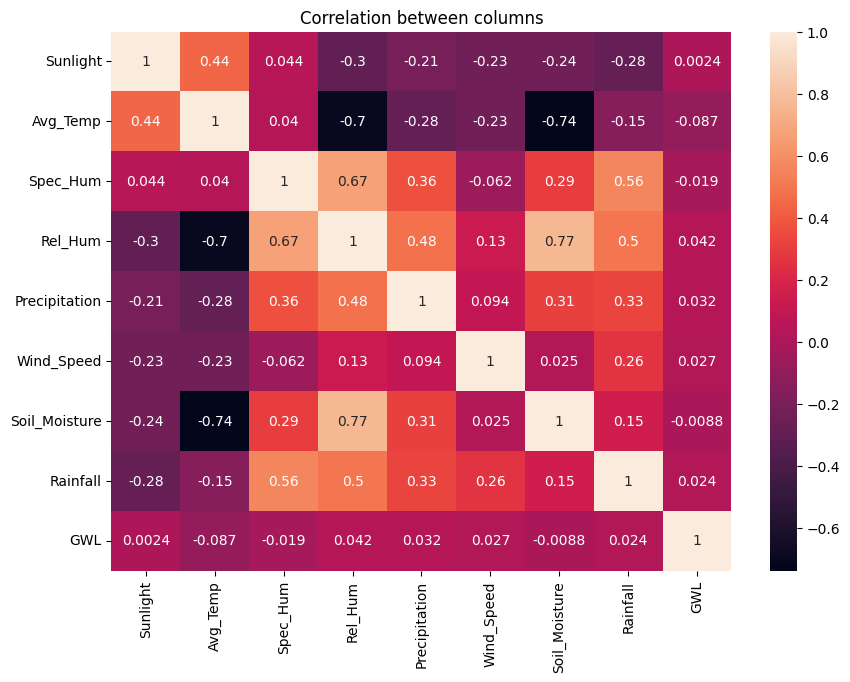

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation between columns')
plt.show()

# Lighter color -> higher correlation value
# Darker color -> lower correlation value

In [ ]:
x = data.drop(columns = 'GWL')
x

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall
0,19.709999,27.070000,15.38,71.750000,0.00,1.23,0.52,379.600006
1,19.670000,27.100000,15.08,70.809998,0.00,1.16,0.51,401.299988
2,20.420000,27.450001,15.44,70.940002,0.00,1.50,0.51,405.500000
3,19.790001,27.440001,15.62,71.120003,0.00,0.98,0.51,397.899994
4,19.240000,27.540001,15.69,70.879997,0.00,1.24,0.50,384.899994
...,...,...,...,...,...,...,...,...
4013,20.870001,25.160000,10.99,58.939999,0.01,1.03,0.53,348.779999
4014,19.129999,26.980000,15.14,70.809998,0.10,0.90,0.53,372.940002
4015,19.320000,26.480000,13.98,67.690002,0.02,0.71,0.52,366.630005
4016,18.440001,26.440001,15.08,72.879997,0.03,1.38,0.52,367.589996


In [ ]:
y = data['GWL']
y

0       368.899994
1       367.000000
2       365.799988
3       365.799988
4       363.500000
           ...    
4013    483.299988
4014    484.799988
4015    487.500000
4016    484.799988
4017    483.899994
Name: GWL, Length: 4018, dtype: float32

In [ ]:
data.shape

(4018, 9)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42) # Train (80%) and Test (20%)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_train, y_train, test_size = 0.5, random_state = 42) # Validation (10%) and Test (10%)

In [ ]:
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('x_val', x_val.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_val', y_val.shape)

x_train (3214, 8)
x_test (1607, 8)
x_val (1607, 8)
y_train (3214,)
y_test (1607,)
y_val (1607,)


In [ ]:
# Scaling data into numpy arrays
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
x_train

array([[ 0.04781827,  0.08722618,  1.1389925 , ..., -1.3277869 ,
         1.7339075 , -0.23641244],
       [-1.4521008 , -0.16129513,  0.6611977 , ...,  1.4816014 ,
        -0.48906845, -0.04634283],
       [ 1.19046   , -0.44167638, -2.853542  , ..., -0.81698895,
         0.28897312, -5.933135  ],
       ...,
       [ 0.0960988 ,  0.3038852 ,  1.1782631 , ...,  1.4351652 ,
        -0.48906845,  2.0874612 ],
       [-0.5733931 , -1.0534197 , -0.9750871 , ...,  2.0852716 ,
        -0.04447364, -0.36013767],
       [-0.28692785, -0.4353039 , -0.05876786, ..., -1.0723879 ,
         0.28897312,  0.1150363 ]], dtype=float32)

In [ ]:
x_test

array([[-0.40280157, -0.9705789 ,  0.26194382, ...,  1.3887291 ,
         1.5116102 ,  0.50503904],
       [ 1.0488366 ,  0.9729783 ,  0.8248262 , ...,  1.0868938 ,
        -0.8225152 ,  0.38400334],
       [-0.47683176, -0.8431332 ,  0.22267333, ..., -1.0491699 ,
         0.8447173 ,  0.01641451],
       ...,
       [ 0.47268787,  1.2023822 , -0.09803834, ..., -0.3990636 ,
        -0.8225152 , -0.38703603],
       [ 0.7044347 , -0.01473085,  0.8248262 , ..., -1.2349147 ,
         2.0673535 , -0.6237256 ],
       [ 0.86215144, -0.24413477,  0.7790104 , ...,  0.34391522,
         0.8447173 ,  0.9577991 ]], dtype=float32)

In [ ]:
x_val

array([[ 0.06069279,  0.9474897 , -1.0928998 , ..., -0.35262746,
        -1.1559613 , -2.1622174 ],
       [ 1.171148  ,  0.4759369 ,  0.90336716, ...,  0.22782461,
         0.06667572, -0.37179336],
       [ 0.05103644, -1.5440886 ,  0.01977437, ...,  0.25104296,
         1.9562049 ,  0.14193465],
       ...,
       [-1.2267911 , -1.4548753 , -0.29439327, ...,  2.0852716 ,
         0.95586604,  1.334354  ],
       [-0.9338886 , -0.66470784,  1.0211799 , ..., -0.46871775,
         1.4004614 ,  1.5584933 ],
       [ 0.41153222, -0.63921916,  0.90336716, ...,  0.2974791 ,
         1.9562049 ,  0.8860756 ]], dtype=float32)

In [ ]:
print(x_train.shape[1])

epochs = 2000
batch_size = 50
patience = 100

8


### 1. Feed-Forward Neural Network

2024/01/28 19:55:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmps2__7fqw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmps2__7fqw\model\data\model\assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              9000      
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 635001 (2.42 MB)
Trainable params: 635001 (2.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Epoch 1/2000



65/65 [==============================] - 2s 12ms/step - loss: 38684.6602 - mae: 158.3449 - val_loss: 25681.8496 - val_mae: 121.6243
Epoch 2/2000
65/65 [==============================] - 1s 9ms/step - loss: 19373.3320 - mae: 116.3595 - val_loss: 18230.2207 - val_mae: 109.6916
Epoch 3/2000
65/65 [==============================] - 1s 8ms/step - loss: 18123.8848 - mae: 112.3457 - val_loss: 18566.6055 - val_mae: 106.6887
Epoch 4/2000
65/65 [==============================] - 1s 9ms/step - loss: 17158.5957 - mae: 109.3900 - val_loss: 16703.5137 - val_mae: 106.9123
Epoch 5/2000
65/65 [==============================] - 1s 8ms/step - loss: 16826.3828 - mae: 108.6270 - val_loss: 16976.7324 - val_mae: 113.2011
Epoch 6/2000
65/65 [==============================] - 1s 9ms/step - loss: 16463.6230 - mae: 107.9564 - val_loss: 16823.2129 - val_mae: 102.3031
Epoch 7/2000
65/65 [==============================] - 1s 9ms/step - loss: 16310.1855 - mae: 107.1364 - val_loss: 17473.9668 - val_mae: 100.6894
Epoc

Epoch 58/2000
65/65 [==============================] - 1s 10ms/step - loss: 13337.4521 - mae: 95.2912 - val_loss: 13455.6719 - val_mae: 91.6394
Epoch 59/2000
65/65 [==============================] - 1s 11ms/step - loss: 13283.8994 - mae: 94.3427 - val_loss: 14373.2246 - val_mae: 91.5473
Epoch 60/2000
65/65 [==============================] - 1s 9ms/step - loss: 13219.5781 - mae: 94.6744 - val_loss: 12948.6133 - val_mae: 94.9348
Epoch 61/2000
65/65 [==============================] - 1s 11ms/step - loss: 13322.5898 - mae: 95.1325 - val_loss: 21587.8887 - val_mae: 109.7104
Epoch 62/2000
65/65 [==============================] - 1s 10ms/step - loss: 13342.4355 - mae: 94.8997 - val_loss: 13539.8594 - val_mae: 99.8090
Epoch 63/2000
65/65 [==============================] - 1s 10ms/step - loss: 13064.2178 - mae: 93.6923 - val_loss: 13048.4121 - val_mae: 97.3957
Epoch 64/2000
65/65 [==============================] - 1s 10ms/step - loss: 13128.6982 - mae: 93.9945 - val_loss: 12854.5654 - val_mae: 

Epoch 115/2000
65/65 [==============================] - 1s 10ms/step - loss: 10784.4160 - mae: 83.2610 - val_loss: 10760.2910 - val_mae: 83.1502
Epoch 116/2000
65/65 [==============================] - 1s 10ms/step - loss: 10640.4297 - mae: 82.9474 - val_loss: 11886.8662 - val_mae: 91.8142
Epoch 117/2000
65/65 [==============================] - 1s 10ms/step - loss: 10844.3350 - mae: 83.4197 - val_loss: 11707.9561 - val_mae: 92.9447
Epoch 118/2000
65/65 [==============================] - 1s 10ms/step - loss: 10629.2520 - mae: 82.5534 - val_loss: 14655.6650 - val_mae: 103.8847
Epoch 119/2000
65/65 [==============================] - 1s 11ms/step - loss: 10720.6758 - mae: 83.1617 - val_loss: 10609.7266 - val_mae: 81.0673
Epoch 120/2000
65/65 [==============================] - 1s 10ms/step - loss: 10472.5596 - mae: 81.9171 - val_loss: 10634.9082 - val_mae: 82.9578
Epoch 121/2000
65/65 [==============================] - 1s 10ms/step - loss: 10571.8994 - mae: 82.1612 - val_loss: 13478.7070 - v

Epoch 172/2000
65/65 [==============================] - 1s 10ms/step - loss: 7729.1357 - mae: 68.3823 - val_loss: 8638.4951 - val_mae: 75.3720
Epoch 173/2000
65/65 [==============================] - 1s 9ms/step - loss: 7734.0752 - mae: 68.7443 - val_loss: 7857.5503 - val_mae: 68.0733
Epoch 174/2000
65/65 [==============================] - 1s 11ms/step - loss: 7731.9521 - mae: 69.2607 - val_loss: 9847.2100 - val_mae: 80.3125
Epoch 175/2000
65/65 [==============================] - 1s 10ms/step - loss: 7832.8501 - mae: 68.8733 - val_loss: 8995.4082 - val_mae: 72.8628
Epoch 176/2000
65/65 [==============================] - 1s 10ms/step - loss: 7680.9707 - mae: 68.1882 - val_loss: 9240.9160 - val_mae: 73.8991
Epoch 177/2000
65/65 [==============================] - 1s 10ms/step - loss: 7632.6504 - mae: 68.2368 - val_loss: 10908.7861 - val_mae: 84.6064
Epoch 178/2000
65/65 [==============================] - 1s 11ms/step - loss: 7674.0088 - mae: 68.2684 - val_loss: 7853.3203 - val_mae: 69.9793

65/65 [==============================] - 1s 11ms/step - loss: 5049.8896 - mae: 54.5673 - val_loss: 4958.2554 - val_mae: 54.6931
Epoch 230/2000
65/65 [==============================] - 1s 10ms/step - loss: 4789.2236 - mae: 52.7391 - val_loss: 5368.8882 - val_mae: 55.8811
Epoch 231/2000
65/65 [==============================] - 1s 11ms/step - loss: 4896.5459 - mae: 53.9285 - val_loss: 4114.2124 - val_mae: 49.0937
Epoch 232/2000
65/65 [==============================] - 1s 10ms/step - loss: 4843.9424 - mae: 53.3452 - val_loss: 5028.8081 - val_mae: 56.4244
Epoch 233/2000
65/65 [==============================] - 1s 10ms/step - loss: 4737.7939 - mae: 52.6510 - val_loss: 4918.5625 - val_mae: 55.3775
Epoch 234/2000
65/65 [==============================] - 1s 11ms/step - loss: 4800.7773 - mae: 52.9717 - val_loss: 3942.6033 - val_mae: 48.6478
Epoch 235/2000
65/65 [==============================] - 1s 11ms/step - loss: 4733.4678 - mae: 53.0883 - val_loss: 5032.1353 - val_mae: 54.7301
Epoch 236/2000

65/65 [==============================] - 1s 10ms/step - loss: 3113.9021 - mae: 42.3297 - val_loss: 3499.7373 - val_mae: 46.9405
Epoch 287/2000
65/65 [==============================] - 1s 11ms/step - loss: 3179.7402 - mae: 42.9665 - val_loss: 4823.9243 - val_mae: 53.9444
Epoch 288/2000
65/65 [==============================] - 1s 10ms/step - loss: 3206.9221 - mae: 42.5063 - val_loss: 4419.1787 - val_mae: 51.2619
Epoch 289/2000
65/65 [==============================] - 1s 10ms/step - loss: 3328.7358 - mae: 44.5700 - val_loss: 3522.5181 - val_mae: 45.4913
Epoch 290/2000
65/65 [==============================] - 1s 11ms/step - loss: 3242.3516 - mae: 43.5488 - val_loss: 5011.8228 - val_mae: 53.4330
Epoch 291/2000
65/65 [==============================] - 1s 11ms/step - loss: 3196.0417 - mae: 42.9623 - val_loss: 2996.1436 - val_mae: 42.3211
Epoch 292/2000
65/65 [==============================] - 1s 11ms/step - loss: 3124.9050 - mae: 42.5836 - val_loss: 3255.2849 - val_mae: 43.3202
Epoch 293/2000

65/65 [==============================] - 1s 11ms/step - loss: 2167.6013 - mae: 36.0370 - val_loss: 5626.2065 - val_mae: 57.4765
Epoch 344/2000
65/65 [==============================] - 1s 11ms/step - loss: 2337.8223 - mae: 36.3603 - val_loss: 2024.0532 - val_mae: 33.8652
Epoch 345/2000
65/65 [==============================] - 1s 11ms/step - loss: 2235.8879 - mae: 36.1857 - val_loss: 5410.6396 - val_mae: 57.1126
Epoch 346/2000
65/65 [==============================] - 1s 10ms/step - loss: 2235.2437 - mae: 35.6811 - val_loss: 1955.6682 - val_mae: 33.9233
Epoch 347/2000
65/65 [==============================] - 1s 11ms/step - loss: 2323.2163 - mae: 36.6185 - val_loss: 2061.6328 - val_mae: 33.3196
Epoch 348/2000
65/65 [==============================] - 1s 11ms/step - loss: 2261.8467 - mae: 35.9662 - val_loss: 2603.9026 - val_mae: 39.0567
Epoch 349/2000
65/65 [==============================] - 1s 11ms/step - loss: 2241.6482 - mae: 36.0367 - val_loss: 2140.0208 - val_mae: 35.9563
Epoch 350/2000

65/65 [==============================] - 1s 8ms/step - loss: 1844.3423 - mae: 32.5513 - val_loss: 1668.5109 - val_mae: 31.5252
Epoch 401/2000
65/65 [==============================] - 1s 10ms/step - loss: 1704.5033 - mae: 31.4237 - val_loss: 2015.1660 - val_mae: 33.4036
Epoch 402/2000
65/65 [==============================] - 1s 11ms/step - loss: 1741.3508 - mae: 32.0168 - val_loss: 2018.8967 - val_mae: 35.5715
Epoch 403/2000
65/65 [==============================] - 1s 10ms/step - loss: 1705.0490 - mae: 31.6486 - val_loss: 1383.4071 - val_mae: 28.9397
Epoch 404/2000
65/65 [==============================] - 1s 11ms/step - loss: 1758.5168 - mae: 32.0918 - val_loss: 1551.1259 - val_mae: 30.8646
Epoch 405/2000
65/65 [==============================] - 1s 11ms/step - loss: 1713.4585 - mae: 31.6662 - val_loss: 1895.5815 - val_mae: 33.6741
Epoch 406/2000
65/65 [==============================] - 1s 11ms/step - loss: 1697.7104 - mae: 31.4197 - val_loss: 1777.4376 - val_mae: 32.2700
Epoch 407/2000


65/65 [==============================] - 1s 10ms/step - loss: 1308.2812 - mae: 27.3402 - val_loss: 1490.5925 - val_mae: 28.4339
Epoch 458/2000
65/65 [==============================] - 1s 10ms/step - loss: 1346.3279 - mae: 28.1615 - val_loss: 1668.8883 - val_mae: 32.9090
Epoch 459/2000
65/65 [==============================] - 1s 10ms/step - loss: 1329.8583 - mae: 27.8357 - val_loss: 1407.5745 - val_mae: 29.0248
Epoch 460/2000
65/65 [==============================] - 1s 10ms/step - loss: 1297.7994 - mae: 27.4447 - val_loss: 1839.2371 - val_mae: 32.3550
Epoch 461/2000
65/65 [==============================] - 1s 10ms/step - loss: 1349.0406 - mae: 28.1949 - val_loss: 907.0420 - val_mae: 22.4944
Epoch 462/2000
65/65 [==============================] - 1s 11ms/step - loss: 1370.0833 - mae: 28.1367 - val_loss: 2422.9443 - val_mae: 37.5948
Epoch 463/2000
65/65 [==============================] - 1s 10ms/step - loss: 1350.9510 - mae: 28.0092 - val_loss: 1609.6948 - val_mae: 31.4504
Epoch 464/2000


65/65 [==============================] - 1s 10ms/step - loss: 1138.8051 - mae: 25.8492 - val_loss: 1164.6875 - val_mae: 25.9296
Epoch 515/2000
65/65 [==============================] - 1s 10ms/step - loss: 1068.9286 - mae: 24.5731 - val_loss: 986.5099 - val_mae: 24.1587
Epoch 516/2000
65/65 [==============================] - 1s 9ms/step - loss: 1031.0239 - mae: 24.4584 - val_loss: 792.1649 - val_mae: 21.4576
Epoch 517/2000
65/65 [==============================] - 1s 10ms/step - loss: 1075.1478 - mae: 24.8695 - val_loss: 1113.2731 - val_mae: 26.0578
Epoch 518/2000
65/65 [==============================] - 1s 11ms/step - loss: 1134.3447 - mae: 25.9535 - val_loss: 845.4855 - val_mae: 23.0789
Epoch 519/2000
65/65 [==============================] - 1s 11ms/step - loss: 1085.0658 - mae: 24.8897 - val_loss: 2209.5593 - val_mae: 36.7835
Epoch 520/2000
65/65 [==============================] - 1s 10ms/step - loss: 1083.6130 - mae: 24.9233 - val_loss: 982.4957 - val_mae: 23.4397
Epoch 521/2000
65/6

Epoch 572/2000
65/65 [==============================] - 1s 10ms/step - loss: 862.5378 - mae: 22.0756 - val_loss: 1263.8087 - val_mae: 25.8779
Epoch 573/2000
65/65 [==============================] - 1s 10ms/step - loss: 969.6136 - mae: 23.9327 - val_loss: 1150.9165 - val_mae: 26.6179
Epoch 574/2000
65/65 [==============================] - 1s 11ms/step - loss: 892.4488 - mae: 22.6690 - val_loss: 979.3402 - val_mae: 23.7362
Epoch 575/2000
65/65 [==============================] - 1s 11ms/step - loss: 900.6871 - mae: 23.2482 - val_loss: 818.7203 - val_mae: 21.6293
Epoch 576/2000
65/65 [==============================] - 1s 10ms/step - loss: 987.6987 - mae: 24.3144 - val_loss: 748.9135 - val_mae: 21.2711
Epoch 577/2000
65/65 [==============================] - 1s 10ms/step - loss: 869.2012 - mae: 22.2849 - val_loss: 1047.1821 - val_mae: 25.7448
Epoch 578/2000
65/65 [==============================] - 1s 11ms/step - loss: 936.9523 - mae: 23.8964 - val_loss: 1077.1721 - val_mae: 25.0981
Epoch 579

Epoch 630/2000
65/65 [==============================] - 1s 10ms/step - loss: 780.9728 - mae: 21.4284 - val_loss: 937.9580 - val_mae: 23.1995
Epoch 631/2000
65/65 [==============================] - 1s 10ms/step - loss: 800.3428 - mae: 21.6442 - val_loss: 1525.7010 - val_mae: 30.2217
Epoch 632/2000
65/65 [==============================] - 1s 10ms/step - loss: 817.7899 - mae: 21.3361 - val_loss: 449.3617 - val_mae: 15.9843
Epoch 633/2000
65/65 [==============================] - 1s 10ms/step - loss: 729.8314 - mae: 20.4639 - val_loss: 919.7635 - val_mae: 22.4264
Epoch 634/2000
65/65 [==============================] - 1s 10ms/step - loss: 774.2230 - mae: 21.4588 - val_loss: 663.7763 - val_mae: 19.6609
Epoch 635/2000
65/65 [==============================] - 1s 10ms/step - loss: 773.1681 - mae: 21.0463 - val_loss: 756.9924 - val_mae: 21.1779
Epoch 636/2000
65/65 [==============================] - 1s 10ms/step - loss: 760.6279 - mae: 21.2121 - val_loss: 443.5786 - val_mae: 16.1595
Epoch 637/20

65/65 [==============================] - 1s 10ms/step - loss: 671.4792 - mae: 19.8246 - val_loss: 1584.1157 - val_mae: 31.7696
Epoch 689/2000
65/65 [==============================] - 1s 10ms/step - loss: 689.8396 - mae: 20.0212 - val_loss: 1140.4806 - val_mae: 26.6471
Epoch 690/2000
65/65 [==============================] - 1s 10ms/step - loss: 685.4445 - mae: 20.0472 - val_loss: 867.1630 - val_mae: 22.2143
Epoch 691/2000
65/65 [==============================] - 1s 9ms/step - loss: 644.4609 - mae: 19.1567 - val_loss: 817.6114 - val_mae: 22.2594
Epoch 692/2000
65/65 [==============================] - 1s 10ms/step - loss: 679.0192 - mae: 19.9085 - val_loss: 572.1231 - val_mae: 18.9053
Epoch 693/2000
65/65 [==============================] - 1s 10ms/step - loss: 680.8355 - mae: 19.6796 - val_loss: 745.1214 - val_mae: 20.3232
Epoch 694/2000
65/65 [==============================] - 1s 9ms/step - loss: 694.6673 - mae: 20.1794 - val_loss: 590.3091 - val_mae: 18.4417
Epoch 695/2000
65/65 [======

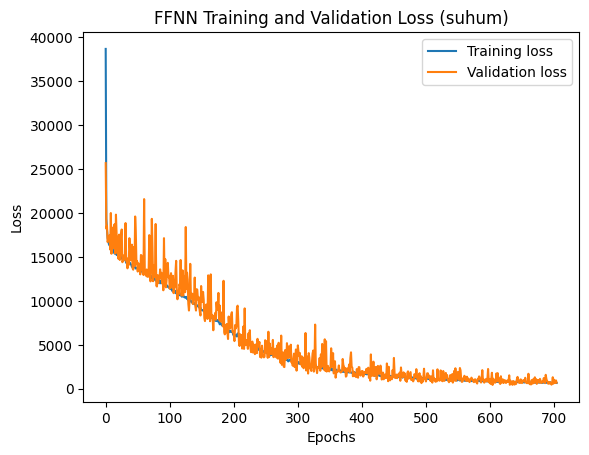

51/51 [==============================] - 0s 3ms/step


<Figure size 640x480 with 0 Axes>

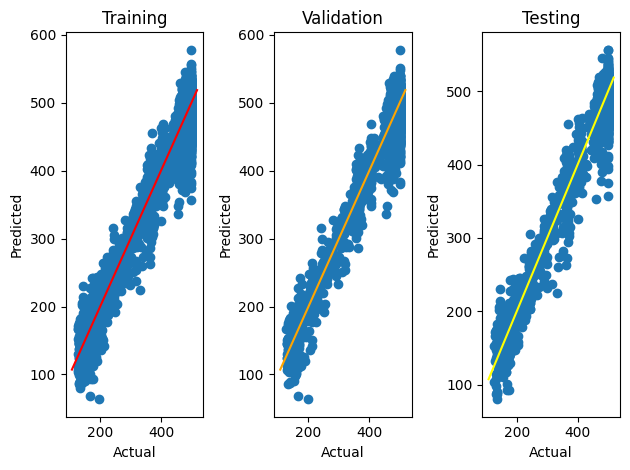

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_ffn_saved_model\assets


INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_ffn_saved_model\assets


<Figure size 640x480 with 0 Axes>

In [ ]:
# Start MLflow run
with mlflow.start_run():

    # Log parameters
    mlflow.set_tag("programmer", "Berchie")

    mlflow.set_tag("model_type", "feedforward_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.set_tag("experiment", "Suhum")
    mlflow.log_param("Data-path", r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Suhum.csv")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)

    # Feed forward neural network model architecture
    ffn_model = Sequential()
    ffn_model.add(Input(shape=(x_train.shape[1],)))
    ffn_model.add(Dense(1000, activation='relu'))
    ffn_model.add(Dense(500, activation='relu'))
    ffn_model.add(Dense(250, activation='linear'))
    ffn_model.add(Dense(1, activation='linear'))

    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(ffn_model, 'suhum_ffn_model')
    ffn_model.summary()

    # Define your model
    ffn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                            mode='min',
                            patience=patience)


    # Train the model
    history = ffn_model.fit(x_train, y_train,
                            epochs=epochs,
                            callbacks=[earlyStop],
                            batch_size=batch_size,
                            validation_data=(x_val, y_val),
                            verbose=1)

    # Log final metrics
    mlflow.log_metric("suhum_final_training_loss", history.history['loss'][-1])
    mlflow.log_metric("suhum_final_validation_loss", history.history['val_loss'][-1])

    # Predictions
    train_preds = ffn_model.predict(x_train)
    val_preds = ffn_model.predict(x_val)
    test_preds = ffn_model.predict(x_test)

    # Evaluation on test set
    ffn_results = ffn_model.evaluate(x_test, y_test)

    # MAE
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    test_mae = ffn_results[1]

    # MSE
    train_mse = mean_squared_error(y_train, train_preds)
    val_mse = mean_squared_error(y_val, val_preds)
    test_mse = ffn_results[0]

    # RMSE
    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)
    test_rmse = np.sqrt(test_mse)

    # R-Square
    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)
    test_r2 = r2_score(y_test, test_preds)

    # MAPE
    train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

    # AIC calculation for the feed-forward neural network
    n_samples = len(y_train)
    log_likelihood = -0.5 * n_samples * np.log(2 * np.pi * train_mse) - 0.5 * n_samples

    # Number of parameters in the model
    n_params = sum([np.prod(w.shape) for w in ffn_model.get_weights()])

    # Calculate AIC
    aic_ffn = -2 * log_likelihood + 2 * n_params

    # Log AIC as a metric
    mlflow.log_metric("suhum_aic_ffn", aic_ffn)

    # Logging metrics
    mlflow.log_metric("suhum_train_mae", train_mae)
    mlflow.log_metric("suhum_val_mae", val_mae)
    mlflow.log_metric("suhum_test_mae", test_mae)

    mlflow.log_metric("suhum_train_mse", train_mse)
    mlflow.log_metric("suhum_val_mse", val_mse)
    mlflow.log_metric("suhum_test_mse", test_mse)

    mlflow.log_metric("suhum_train_rmse", train_rmse)
    mlflow.log_metric("suhum_val_rmse", val_rmse)
    mlflow.log_metric("suhum_test_rmse", test_rmse)

    mlflow.log_metric("suhum_train_r2", train_r2)
    mlflow.log_metric("suhum_val_r2", val_r2)
    mlflow.log_metric("suhum_test_r2", test_r2)

    mlflow.log_metric("suhum_train_mape", train_mape)
    mlflow.log_metric("suhum_val_mape", val_mape)
    mlflow.log_metric("suhum_test_mape", test_mape)

    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('FFNN Training and Validation Loss (suhum)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Directory to save the plot
    plot_directory = "D:\\RGT\\Code\\Practice\\Deep Learning for GWL Changes\\Artifacts"
    os.makedirs(plot_directory, exist_ok=True)

    loss_plot_path = os.path.join(plot_directory, "suhum_ffn_loss_plot.png")
    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)

    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    test_preds = ffn_model.predict(x_test)
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("Testing")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='yellow')

    # Tight layout
    fig.tight_layout()
    plt.show()

    # Save scatter plot
    scatter_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_ffn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)


    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_ffn_saved_model'
    ffn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)

    mlflow.end_run()


### 2. Convolutional Neural Network

In [ ]:
# Reshape data for CNN
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train_cnn.shape)

x_val_cnn = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(x_val_cnn.shape)

x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test_cnn.shape)

(3214, 8, 1)
(1607, 8, 1)
(1607, 8, 1)



2024/01/28 20:03:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpxfq57vuf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpxfq57vuf\model\data\model\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 1000)           4000      
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 1000)           0         
 D)                                                              
                                                                 
 dense_4 (Dense)             (None, 3, 500)            500500    
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 250)               375250    
                                                                 
 dense_6 (Dense)             (None, 1)                 251       
                                                      

65/65 [==============================] - 1s 20ms/step - loss: 15512.7559 - mae: 105.6241 - val_loss: 15581.5703 - val_mae: 106.0536
Epoch 49/2000
65/65 [==============================] - 1s 18ms/step - loss: 15314.9785 - mae: 104.7719 - val_loss: 15911.8623 - val_mae: 100.3016
Epoch 50/2000
65/65 [==============================] - 1s 19ms/step - loss: 15511.2520 - mae: 104.9432 - val_loss: 15386.0361 - val_mae: 107.8031
Epoch 51/2000
65/65 [==============================] - 1s 19ms/step - loss: 15424.9121 - mae: 105.3571 - val_loss: 15604.5889 - val_mae: 103.6265
Epoch 52/2000
65/65 [==============================] - 1s 19ms/step - loss: 15330.1631 - mae: 104.8158 - val_loss: 15290.2129 - val_mae: 104.3724
Epoch 53/2000
65/65 [==============================] - 1s 18ms/step - loss: 15363.3682 - mae: 104.7187 - val_loss: 16358.0264 - val_mae: 114.4921
Epoch 54/2000
65/65 [==============================] - 1s 19ms/step - loss: 15558.4180 - mae: 105.2477 - val_loss: 15266.2051 - val_mae: 1

65/65 [==============================] - 1s 19ms/step - loss: 14687.9375 - mae: 102.0091 - val_loss: 15214.8672 - val_mae: 108.3312
Epoch 105/2000
65/65 [==============================] - 1s 18ms/step - loss: 15032.9209 - mae: 102.1499 - val_loss: 14985.9912 - val_mae: 107.1639
Epoch 106/2000
65/65 [==============================] - 1s 19ms/step - loss: 14770.4043 - mae: 102.1484 - val_loss: 14846.9531 - val_mae: 105.9663
Epoch 107/2000
65/65 [==============================] - 1s 20ms/step - loss: 14432.5166 - mae: 100.9736 - val_loss: 16033.3018 - val_mae: 97.3922
Epoch 108/2000
65/65 [==============================] - 1s 19ms/step - loss: 14681.7959 - mae: 101.6107 - val_loss: 14455.8975 - val_mae: 99.3937
Epoch 109/2000
65/65 [==============================] - 1s 19ms/step - loss: 14613.5889 - mae: 102.0213 - val_loss: 14547.6475 - val_mae: 97.8842
Epoch 110/2000
65/65 [==============================] - 1s 18ms/step - loss: 14707.5908 - mae: 101.5248 - val_loss: 15084.5078 - val_mae

65/65 [==============================] - 1s 18ms/step - loss: 13697.0518 - mae: 97.6781 - val_loss: 13577.2852 - val_mae: 97.6182
Epoch 161/2000
65/65 [==============================] - 1s 19ms/step - loss: 13770.3662 - mae: 97.5864 - val_loss: 13631.2666 - val_mae: 95.4140
Epoch 162/2000
65/65 [==============================] - 1s 19ms/step - loss: 13707.2656 - mae: 97.2542 - val_loss: 13826.0957 - val_mae: 99.6096
Epoch 163/2000
65/65 [==============================] - 1s 19ms/step - loss: 13702.4248 - mae: 97.5379 - val_loss: 13708.5762 - val_mae: 99.8920
Epoch 164/2000
65/65 [==============================] - 1s 19ms/step - loss: 13850.6309 - mae: 97.8542 - val_loss: 14024.5938 - val_mae: 103.1593
Epoch 165/2000
65/65 [==============================] - 1s 19ms/step - loss: 13599.0596 - mae: 96.9817 - val_loss: 13470.1943 - val_mae: 95.9709
Epoch 166/2000
65/65 [==============================] - 1s 19ms/step - loss: 13540.9922 - mae: 96.7507 - val_loss: 13788.6631 - val_mae: 95.6722

65/65 [==============================] - 1s 19ms/step - loss: 13348.0830 - mae: 95.2310 - val_loss: 12570.8672 - val_mae: 91.8665
Epoch 217/2000
65/65 [==============================] - 1s 19ms/step - loss: 12585.9141 - mae: 92.0183 - val_loss: 12703.1895 - val_mae: 95.4402
Epoch 218/2000
65/65 [==============================] - 1s 19ms/step - loss: 13039.7832 - mae: 94.0674 - val_loss: 12834.4043 - val_mae: 96.3098
Epoch 219/2000
65/65 [==============================] - 1s 19ms/step - loss: 12519.7021 - mae: 92.2093 - val_loss: 12516.1221 - val_mae: 91.5293
Epoch 220/2000
65/65 [==============================] - 1s 18ms/step - loss: 12516.3672 - mae: 92.3975 - val_loss: 12488.7676 - val_mae: 92.7634
Epoch 221/2000
65/65 [==============================] - 1s 19ms/step - loss: 12574.0225 - mae: 91.9942 - val_loss: 12638.6299 - val_mae: 95.6834
Epoch 222/2000
65/65 [==============================] - 1s 19ms/step - loss: 12404.5488 - mae: 91.5328 - val_loss: 12311.2168 - val_mae: 92.7513


65/65 [==============================] - 1s 19ms/step - loss: 11292.5244 - mae: 86.4785 - val_loss: 10900.6182 - val_mae: 83.3719
Epoch 273/2000
65/65 [==============================] - 1s 19ms/step - loss: 11414.0762 - mae: 87.2486 - val_loss: 11651.6289 - val_mae: 90.7883
Epoch 274/2000
65/65 [==============================] - 1s 19ms/step - loss: 11302.9785 - mae: 86.7812 - val_loss: 11089.9580 - val_mae: 86.2014
Epoch 275/2000
65/65 [==============================] - 1s 18ms/step - loss: 11411.0918 - mae: 86.6846 - val_loss: 10863.7773 - val_mae: 83.5019
Epoch 276/2000
65/65 [==============================] - 1s 19ms/step - loss: 11288.5518 - mae: 86.5588 - val_loss: 11297.2783 - val_mae: 89.1708
Epoch 277/2000
65/65 [==============================] - 1s 19ms/step - loss: 11162.4805 - mae: 85.4512 - val_loss: 11229.5645 - val_mae: 86.6272
Epoch 278/2000
65/65 [==============================] - 1s 19ms/step - loss: 11173.3008 - mae: 86.5230 - val_loss: 11254.7715 - val_mae: 82.8684


65/65 [==============================] - 1s 20ms/step - loss: 9980.0713 - mae: 80.2087 - val_loss: 9402.9355 - val_mae: 77.2200
Epoch 329/2000
65/65 [==============================] - 1s 20ms/step - loss: 10031.6475 - mae: 80.8705 - val_loss: 9893.2920 - val_mae: 78.7056
Epoch 330/2000
65/65 [==============================] - 1s 20ms/step - loss: 9896.3096 - mae: 80.0373 - val_loss: 9610.6182 - val_mae: 78.0882
Epoch 331/2000
65/65 [==============================] - 1s 20ms/step - loss: 9848.3633 - mae: 80.2836 - val_loss: 9362.4932 - val_mae: 77.9499
Epoch 332/2000
65/65 [==============================] - 1s 20ms/step - loss: 9968.6143 - mae: 80.8168 - val_loss: 10046.3486 - val_mae: 78.5656
Epoch 333/2000
65/65 [==============================] - 1s 20ms/step - loss: 10341.5508 - mae: 81.5371 - val_loss: 9519.5635 - val_mae: 78.7782
Epoch 334/2000
65/65 [==============================] - 1s 20ms/step - loss: 9912.5840 - mae: 80.0599 - val_loss: 9471.8486 - val_mae: 79.3417
Epoch 335/2

65/65 [==============================] - 1s 19ms/step - loss: 8494.2178 - mae: 73.3000 - val_loss: 8234.7295 - val_mae: 70.4851
Epoch 386/2000
65/65 [==============================] - 1s 20ms/step - loss: 8779.7373 - mae: 74.4432 - val_loss: 9078.6934 - val_mae: 73.5776
Epoch 387/2000
65/65 [==============================] - 1s 20ms/step - loss: 8497.5596 - mae: 73.2609 - val_loss: 8117.2041 - val_mae: 72.3757
Epoch 388/2000
65/65 [==============================] - 1s 20ms/step - loss: 8353.3203 - mae: 72.7906 - val_loss: 7880.8184 - val_mae: 69.2644
Epoch 389/2000
65/65 [==============================] - 1s 20ms/step - loss: 8419.8877 - mae: 72.9685 - val_loss: 7907.6953 - val_mae: 69.8109
Epoch 390/2000
65/65 [==============================] - 1s 19ms/step - loss: 8573.6289 - mae: 73.1684 - val_loss: 8153.8926 - val_mae: 72.8317
Epoch 391/2000
65/65 [==============================] - 1s 19ms/step - loss: 8749.8154 - mae: 74.2021 - val_loss: 8535.3740 - val_mae: 73.8332
Epoch 392/2000

65/65 [==============================] - 1s 20ms/step - loss: 7154.3818 - mae: 66.2565 - val_loss: 6968.9351 - val_mae: 65.0811
Epoch 443/2000
65/65 [==============================] - 1s 20ms/step - loss: 7145.4912 - mae: 66.9482 - val_loss: 6629.9551 - val_mae: 62.4453
Epoch 444/2000
65/65 [==============================] - 1s 20ms/step - loss: 7057.1675 - mae: 66.0993 - val_loss: 6942.8452 - val_mae: 65.4753
Epoch 445/2000
65/65 [==============================] - 1s 20ms/step - loss: 7084.2593 - mae: 66.1183 - val_loss: 6697.8843 - val_mae: 64.9068
Epoch 446/2000
65/65 [==============================] - 1s 20ms/step - loss: 7173.7637 - mae: 66.7878 - val_loss: 6785.0371 - val_mae: 63.8111
Epoch 447/2000
65/65 [==============================] - 1s 20ms/step - loss: 7194.4990 - mae: 66.6258 - val_loss: 7202.7480 - val_mae: 65.4178
Epoch 448/2000
65/65 [==============================] - 1s 20ms/step - loss: 7093.8271 - mae: 66.1969 - val_loss: 6873.4336 - val_mae: 63.4212
Epoch 449/2000

65/65 [==============================] - 1s 20ms/step - loss: 5989.3174 - mae: 59.9045 - val_loss: 5602.3530 - val_mae: 57.6508
Epoch 500/2000
65/65 [==============================] - 1s 19ms/step - loss: 5881.0122 - mae: 59.4896 - val_loss: 5546.3770 - val_mae: 57.0535
Epoch 501/2000
65/65 [==============================] - 1s 20ms/step - loss: 5902.4346 - mae: 59.9104 - val_loss: 5625.3701 - val_mae: 57.8712
Epoch 502/2000
65/65 [==============================] - 1s 19ms/step - loss: 5735.0400 - mae: 58.9538 - val_loss: 5246.7573 - val_mae: 56.1082
Epoch 503/2000
65/65 [==============================] - 1s 20ms/step - loss: 5765.2319 - mae: 59.2354 - val_loss: 5820.8101 - val_mae: 61.1152
Epoch 504/2000
65/65 [==============================] - 1s 20ms/step - loss: 5763.2017 - mae: 58.7673 - val_loss: 5772.5063 - val_mae: 57.3651
Epoch 505/2000
65/65 [==============================] - 1s 20ms/step - loss: 5791.1470 - mae: 59.0551 - val_loss: 5212.2261 - val_mae: 55.8946
Epoch 506/2000

65/65 [==============================] - 1s 19ms/step - loss: 4635.0215 - mae: 52.4799 - val_loss: 4000.3450 - val_mae: 48.3866
Epoch 557/2000
65/65 [==============================] - 1s 20ms/step - loss: 4718.7671 - mae: 53.1457 - val_loss: 4427.3140 - val_mae: 50.6080
Epoch 558/2000
65/65 [==============================] - 1s 20ms/step - loss: 4605.2109 - mae: 52.4593 - val_loss: 4487.8428 - val_mae: 51.4408
Epoch 559/2000
65/65 [==============================] - 1s 20ms/step - loss: 4339.0708 - mae: 51.0022 - val_loss: 3786.4565 - val_mae: 47.1899
Epoch 560/2000
65/65 [==============================] - 1s 20ms/step - loss: 4221.8276 - mae: 49.6076 - val_loss: 3928.1736 - val_mae: 47.3935
Epoch 561/2000
65/65 [==============================] - 1s 19ms/step - loss: 4273.5933 - mae: 50.1989 - val_loss: 3905.2327 - val_mae: 47.5140
Epoch 562/2000
65/65 [==============================] - 1s 19ms/step - loss: 4345.9614 - mae: 50.1993 - val_loss: 4686.6143 - val_mae: 53.3867
Epoch 563/2000

65/65 [==============================] - 1s 20ms/step - loss: 3225.8005 - mae: 43.2528 - val_loss: 2890.9607 - val_mae: 41.4454
Epoch 614/2000
65/65 [==============================] - 1s 20ms/step - loss: 3335.6440 - mae: 44.1513 - val_loss: 3001.7517 - val_mae: 42.1135
Epoch 615/2000
65/65 [==============================] - 1s 20ms/step - loss: 3625.4102 - mae: 46.2329 - val_loss: 2873.6892 - val_mae: 40.7475
Epoch 616/2000
65/65 [==============================] - 1s 20ms/step - loss: 3173.1121 - mae: 42.8470 - val_loss: 2897.2124 - val_mae: 40.8084
Epoch 617/2000
65/65 [==============================] - 1s 20ms/step - loss: 3300.6462 - mae: 43.9722 - val_loss: 3332.5820 - val_mae: 44.3095
Epoch 618/2000
65/65 [==============================] - 1s 20ms/step - loss: 3291.5293 - mae: 43.9235 - val_loss: 3021.6790 - val_mae: 42.3884
Epoch 619/2000
65/65 [==============================] - 1s 20ms/step - loss: 3124.3318 - mae: 42.1474 - val_loss: 3107.4097 - val_mae: 42.2982
Epoch 620/2000

65/65 [==============================] - 1s 15ms/step - loss: 2342.9922 - mae: 36.4393 - val_loss: 2017.8555 - val_mae: 33.8836
Epoch 671/2000
65/65 [==============================] - 1s 12ms/step - loss: 2294.6145 - mae: 36.1915 - val_loss: 2283.1177 - val_mae: 36.8685
Epoch 672/2000
65/65 [==============================] - 1s 15ms/step - loss: 2400.5786 - mae: 37.2400 - val_loss: 1846.7632 - val_mae: 32.4479
Epoch 673/2000
65/65 [==============================] - 1s 20ms/step - loss: 2191.2842 - mae: 35.4398 - val_loss: 1977.1100 - val_mae: 33.7675
Epoch 674/2000
65/65 [==============================] - 1s 20ms/step - loss: 2405.6567 - mae: 36.9930 - val_loss: 2137.4570 - val_mae: 35.5573
Epoch 675/2000
65/65 [==============================] - 1s 19ms/step - loss: 2229.2798 - mae: 35.8064 - val_loss: 1920.1113 - val_mae: 32.6987
Epoch 676/2000
65/65 [==============================] - 1s 19ms/step - loss: 2380.0044 - mae: 36.8790 - val_loss: 2550.5525 - val_mae: 38.6287
Epoch 677/2000

65/65 [==============================] - 1s 20ms/step - loss: 1872.2772 - mae: 32.6026 - val_loss: 2003.9523 - val_mae: 34.2716
Epoch 728/2000
65/65 [==============================] - 1s 20ms/step - loss: 1884.0934 - mae: 32.4923 - val_loss: 1663.3470 - val_mae: 30.4490
Epoch 729/2000
65/65 [==============================] - 1s 20ms/step - loss: 1773.6191 - mae: 31.8837 - val_loss: 1444.2064 - val_mae: 28.8942
Epoch 730/2000
65/65 [==============================] - 1s 20ms/step - loss: 1640.6166 - mae: 30.5855 - val_loss: 1540.9966 - val_mae: 30.3270
Epoch 731/2000
65/65 [==============================] - 1s 20ms/step - loss: 1874.3352 - mae: 32.4285 - val_loss: 1487.9404 - val_mae: 28.9402
Epoch 732/2000
65/65 [==============================] - 1s 19ms/step - loss: 1811.9749 - mae: 32.1377 - val_loss: 1205.8197 - val_mae: 25.4303
Epoch 733/2000
65/65 [==============================] - 1s 20ms/step - loss: 1525.3113 - mae: 29.4451 - val_loss: 1543.6307 - val_mae: 29.7302
Epoch 734/2000

65/65 [==============================] - 1s 19ms/step - loss: 1166.0175 - mae: 25.4993 - val_loss: 903.5703 - val_mae: 21.5820
Epoch 785/2000
65/65 [==============================] - 1s 14ms/step - loss: 1450.6847 - mae: 28.4665 - val_loss: 968.1664 - val_mae: 23.2713
Epoch 786/2000
65/65 [==============================] - 1s 14ms/step - loss: 1133.5957 - mae: 24.9350 - val_loss: 930.6989 - val_mae: 22.6795
Epoch 787/2000
65/65 [==============================] - 1s 20ms/step - loss: 1061.9806 - mae: 24.2960 - val_loss: 873.8413 - val_mae: 21.6884
Epoch 788/2000
65/65 [==============================] - 1s 18ms/step - loss: 1054.0968 - mae: 24.0717 - val_loss: 1012.7327 - val_mae: 23.9025
Epoch 789/2000
65/65 [==============================] - 1s 20ms/step - loss: 1158.4847 - mae: 25.6355 - val_loss: 773.3259 - val_mae: 20.5951
Epoch 790/2000
65/65 [==============================] - 1s 20ms/step - loss: 1060.6810 - mae: 24.3288 - val_loss: 946.8135 - val_mae: 23.7156
Epoch 791/2000
65/65

Epoch 842/2000
65/65 [==============================] - 1s 20ms/step - loss: 781.8002 - mae: 20.9957 - val_loss: 905.0159 - val_mae: 22.4387
Epoch 843/2000
65/65 [==============================] - 1s 21ms/step - loss: 794.4335 - mae: 20.9674 - val_loss: 721.9332 - val_mae: 20.5092
Epoch 844/2000
65/65 [==============================] - 1s 21ms/step - loss: 932.6514 - mae: 22.8161 - val_loss: 748.1779 - val_mae: 20.6078
Epoch 845/2000
65/65 [==============================] - 1s 20ms/step - loss: 829.2761 - mae: 21.7759 - val_loss: 676.9716 - val_mae: 20.0222
Epoch 846/2000
65/65 [==============================] - 1s 20ms/step - loss: 836.5241 - mae: 21.9671 - val_loss: 615.5490 - val_mae: 18.6689
Epoch 847/2000
65/65 [==============================] - 1s 21ms/step - loss: 897.4003 - mae: 22.4128 - val_loss: 904.6096 - val_mae: 22.9473
Epoch 848/2000
65/65 [==============================] - 1s 21ms/step - loss: 903.7126 - mae: 22.4829 - val_loss: 1453.0865 - val_mae: 28.8013
Epoch 849/20

Epoch 900/2000
65/65 [==============================] - 1s 20ms/step - loss: 824.7040 - mae: 21.9284 - val_loss: 590.2162 - val_mae: 18.2750
Epoch 901/2000
65/65 [==============================] - 1s 20ms/step - loss: 722.2380 - mae: 20.6538 - val_loss: 1014.4119 - val_mae: 24.3515
Epoch 902/2000
65/65 [==============================] - 1s 20ms/step - loss: 879.9354 - mae: 22.9025 - val_loss: 472.8499 - val_mae: 16.9488
Epoch 903/2000
65/65 [==============================] - 1s 16ms/step - loss: 666.4526 - mae: 19.6534 - val_loss: 485.6240 - val_mae: 16.8817
Epoch 904/2000
65/65 [==============================] - 1s 16ms/step - loss: 615.5526 - mae: 18.7562 - val_loss: 391.3334 - val_mae: 14.8590
Epoch 905/2000
65/65 [==============================] - 1s 17ms/step - loss: 632.3371 - mae: 18.9359 - val_loss: 512.9271 - val_mae: 17.6052
Epoch 906/2000
65/65 [==============================] - 1s 12ms/step - loss: 588.5989 - mae: 18.0963 - val_loss: 513.7298 - val_mae: 16.9521
Epoch 907/20

65/65 [==============================] - 1s 20ms/step - loss: 700.7496 - mae: 19.8879 - val_loss: 405.4918 - val_mae: 15.4649
Epoch 959/2000
65/65 [==============================] - 1s 20ms/step - loss: 514.1938 - mae: 17.3428 - val_loss: 755.2996 - val_mae: 21.4030
Epoch 960/2000
65/65 [==============================] - 1s 20ms/step - loss: 615.7024 - mae: 18.7935 - val_loss: 509.1880 - val_mae: 17.5814
Epoch 961/2000
65/65 [==============================] - 1s 20ms/step - loss: 592.5538 - mae: 18.6855 - val_loss: 542.2305 - val_mae: 18.3554
Epoch 962/2000
65/65 [==============================] - 1s 21ms/step - loss: 635.6733 - mae: 19.1341 - val_loss: 578.0516 - val_mae: 18.3157
Epoch 963/2000
65/65 [==============================] - 1s 20ms/step - loss: 507.1646 - mae: 17.1978 - val_loss: 391.4514 - val_mae: 14.9893
Epoch 964/2000
65/65 [==============================] - 1s 20ms/step - loss: 532.4929 - mae: 17.5395 - val_loss: 536.0789 - val_mae: 18.1222
Epoch 965/2000
65/65 [======

65/65 [==============================] - 1s 20ms/step - loss: 502.0239 - mae: 17.2483 - val_loss: 397.4598 - val_mae: 15.4088
Epoch 1017/2000
65/65 [==============================] - 1s 19ms/step - loss: 401.9016 - mae: 15.4500 - val_loss: 368.2361 - val_mae: 15.2091
Epoch 1018/2000
65/65 [==============================] - 1s 19ms/step - loss: 384.4987 - mae: 14.9520 - val_loss: 478.5718 - val_mae: 17.3671
Epoch 1019/2000
65/65 [==============================] - 1s 20ms/step - loss: 423.2154 - mae: 15.7728 - val_loss: 489.5842 - val_mae: 17.3065
Epoch 1020/2000
65/65 [==============================] - 1s 20ms/step - loss: 452.8429 - mae: 16.3440 - val_loss: 655.0091 - val_mae: 19.1355
Epoch 1021/2000
65/65 [==============================] - 1s 20ms/step - loss: 568.0820 - mae: 18.2231 - val_loss: 553.3956 - val_mae: 18.3027
Epoch 1022/2000
65/65 [==============================] - 1s 20ms/step - loss: 554.5140 - mae: 18.3794 - val_loss: 518.5799 - val_mae: 17.3554
Epoch 1023/2000
65/65 

Epoch 1074/2000
65/65 [==============================] - 1s 20ms/step - loss: 292.4126 - mae: 12.9440 - val_loss: 357.2617 - val_mae: 13.9907
Epoch 1075/2000
65/65 [==============================] - 1s 20ms/step - loss: 562.8893 - mae: 18.1156 - val_loss: 531.1840 - val_mae: 18.2406
Epoch 1076/2000
65/65 [==============================] - 1s 20ms/step - loss: 698.8812 - mae: 19.9821 - val_loss: 1169.8264 - val_mae: 26.2856
Epoch 1077/2000
65/65 [==============================] - 1s 20ms/step - loss: 1099.5902 - mae: 25.3516 - val_loss: 578.0958 - val_mae: 18.7845
Epoch 1078/2000
65/65 [==============================] - 1s 19ms/step - loss: 563.2874 - mae: 18.0459 - val_loss: 357.2213 - val_mae: 14.7325
Epoch 1079/2000
65/65 [==============================] - 1s 19ms/step - loss: 478.4342 - mae: 16.5636 - val_loss: 381.7872 - val_mae: 15.0456
Epoch 1080/2000
65/65 [==============================] - 1s 20ms/step - loss: 344.6865 - mae: 14.1956 - val_loss: 215.9163 - val_mae: 11.0757
Epoc

65/65 [==============================] - 1s 21ms/step - loss: 342.2951 - mae: 14.4174 - val_loss: 336.6040 - val_mae: 14.0132
Epoch 1132/2000
65/65 [==============================] - 1s 20ms/step - loss: 309.7006 - mae: 13.4916 - val_loss: 264.0203 - val_mae: 12.5710
Epoch 1133/2000
65/65 [==============================] - 1s 21ms/step - loss: 316.7868 - mae: 13.8309 - val_loss: 672.1098 - val_mae: 20.9260
Epoch 1134/2000
65/65 [==============================] - 1s 21ms/step - loss: 426.0968 - mae: 15.6870 - val_loss: 462.9733 - val_mae: 16.3030
Epoch 1135/2000
65/65 [==============================] - 1s 20ms/step - loss: 571.2672 - mae: 17.9382 - val_loss: 620.4699 - val_mae: 19.1070
Epoch 1136/2000
65/65 [==============================] - 1s 20ms/step - loss: 551.9891 - mae: 18.0034 - val_loss: 416.4615 - val_mae: 15.7819
Epoch 1137/2000
65/65 [==============================] - 1s 20ms/step - loss: 402.5427 - mae: 15.3197 - val_loss: 306.4876 - val_mae: 13.4364
Epoch 1138/2000
65/65 

Epoch 1189/2000
65/65 [==============================] - 1s 20ms/step - loss: 321.9216 - mae: 13.7501 - val_loss: 468.4846 - val_mae: 16.6042
Epoch 1190/2000
65/65 [==============================] - 1s 20ms/step - loss: 474.1210 - mae: 16.5734 - val_loss: 388.5058 - val_mae: 15.4996
Epoch 1191/2000
65/65 [==============================] - 1s 20ms/step - loss: 467.7475 - mae: 16.4378 - val_loss: 406.3250 - val_mae: 15.7539
Epoch 1192/2000
65/65 [==============================] - 1s 20ms/step - loss: 397.3336 - mae: 15.5108 - val_loss: 344.9184 - val_mae: 14.5698
Epoch 1193/2000
65/65 [==============================] - 1s 20ms/step - loss: 451.4974 - mae: 16.0270 - val_loss: 398.0859 - val_mae: 15.5548
Epoch 1194/2000
65/65 [==============================] - 1s 21ms/step - loss: 537.9938 - mae: 17.8877 - val_loss: 495.7225 - val_mae: 16.8995
Epoch 1195/2000
65/65 [==============================] - 1s 20ms/step - loss: 520.0444 - mae: 17.4669 - val_loss: 345.4755 - val_mae: 14.0133
Epoch 

Epoch 1247/2000
65/65 [==============================] - 1s 20ms/step - loss: 273.9848 - mae: 12.6675 - val_loss: 335.9770 - val_mae: 13.9902
Epoch 1248/2000
65/65 [==============================] - 1s 21ms/step - loss: 422.8526 - mae: 16.0411 - val_loss: 461.4535 - val_mae: 16.5267
Epoch 1249/2000
65/65 [==============================] - 1s 20ms/step - loss: 436.3613 - mae: 16.1655 - val_loss: 390.3830 - val_mae: 15.5867
Epoch 1250/2000
65/65 [==============================] - 1s 20ms/step - loss: 358.1358 - mae: 14.4889 - val_loss: 262.3075 - val_mae: 12.2431
Epoch 1251/2000
65/65 [==============================] - 1s 20ms/step - loss: 249.6717 - mae: 12.3408 - val_loss: 285.7913 - val_mae: 13.2589
Epoch 1252/2000
65/65 [==============================] - 1s 21ms/step - loss: 233.8802 - mae: 11.5980 - val_loss: 191.5874 - val_mae: 10.5942
Epoch 1253/2000
65/65 [==============================] - 1s 21ms/step - loss: 224.8161 - mae: 11.3739 - val_loss: 161.9613 - val_mae: 9.8580
Epoch 1

Epoch 1305/2000
65/65 [==============================] - 1s 20ms/step - loss: 301.2200 - mae: 13.2561 - val_loss: 175.0401 - val_mae: 10.2049
Epoch 1306/2000
65/65 [==============================] - 1s 20ms/step - loss: 260.1896 - mae: 12.2487 - val_loss: 223.5618 - val_mae: 11.5397
Epoch 1307/2000
65/65 [==============================] - 1s 20ms/step - loss: 264.3354 - mae: 12.6817 - val_loss: 204.8926 - val_mae: 11.2664
Epoch 1308/2000
65/65 [==============================] - 1s 20ms/step - loss: 269.4305 - mae: 12.6857 - val_loss: 506.2833 - val_mae: 17.0758
Epoch 1309/2000
65/65 [==============================] - 1s 20ms/step - loss: 364.3756 - mae: 14.8257 - val_loss: 458.7261 - val_mae: 16.5878
Epoch 1310/2000
65/65 [==============================] - 1s 20ms/step - loss: 301.8069 - mae: 13.3766 - val_loss: 346.8701 - val_mae: 14.5505
Epoch 1311/2000
65/65 [==============================] - 1s 20ms/step - loss: 446.0845 - mae: 16.3717 - val_loss: 259.7254 - val_mae: 12.6116
Epoch 

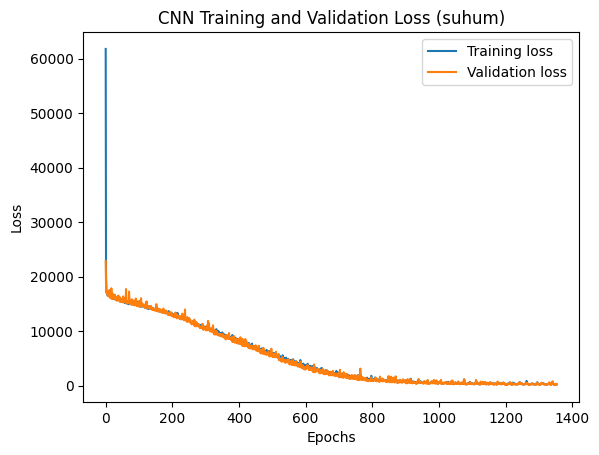

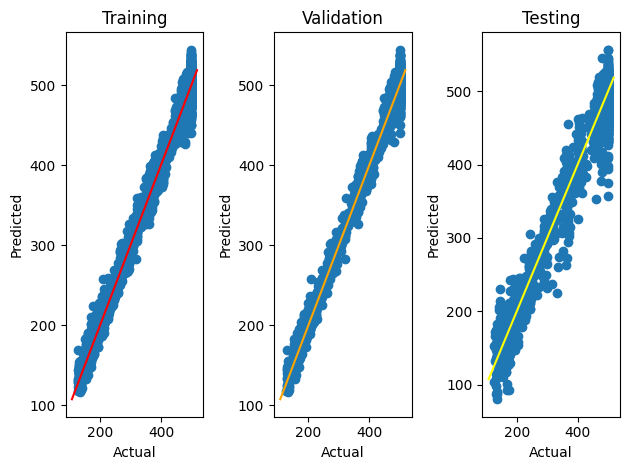

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_cnn_saved_model\assets


INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_cnn_saved_model\assets


<Figure size 640x480 with 0 Axes>

In [ ]:
# Start MLflow run
with mlflow.start_run():

    # Log parameters
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "convolutional_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.set_tag("experiment", "Suhum")
    mlflow.log_param("Data-path", r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Suhum.csv")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)

    #Convolutional neural network model architecture
    cnn_model = Sequential()
    cnn_model.add(Conv1D(1000, 3, activation="relu", input_shape=(x_train.shape[1], 1)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dense(500, activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(250, activation='relu'))
    cnn_model.add(Dense(1, activation='linear'))

    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(cnn_model, 'cnn_model')

    cnn_model.summary()

    cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                             mode='min',
                             patience=patience)

    history = cnn_model.fit(x_train_cnn, y_train,
              		    epochs=epochs,
               		    callbacks=[earlyStop],
               		    batch_size=batch_size,
               		    validation_data=(x_val_cnn, y_val),
               		    verbose=1)
    # Log metrics
    mlflow.log_metric('suhum_final_training_loss', history.history['loss'][-1])
    mlflow.log_metric('suhum_final_validation_loss', history.history['val_loss'][-1])

    # Predictions
    train_preds = cnn_model.predict(x_train_cnn)
    val_preds = cnn_model.predict(x_val_cnn)
    test_preds = cnn_model.predict(x_test_cnn)

    # Evaluate on test set
    cnn_results = cnn_model.evaluate(x_test_cnn, y_test)

    # Mean Absolute Error (MAE)
    cnn_train_mae = mean_absolute_error(y_train, train_preds)
    cnn_val_mae = mean_absolute_error(y_val, val_preds)
    cnn_test_mae = cnn_results[1]

    # Mean Square Error (MAE)
    cnn_train_mse = mean_squared_error(y_train, train_preds)
    cnn_val_mse = mean_squared_error(y_val, val_preds)
    cnn_test_mse = cnn_results[0]

    # Root Mean Squared Error
    cnn_train_rmse = np.sqrt(cnn_train_mse)
    cnn_val_rmse = np.sqrt(cnn_val_mse)
    cnn_test_rmse = np.sqrt(cnn_test_mse)

    # R-Squared
    cnn_train_r2 = r2_score(y_train, train_preds)
    cnn_val_r2 = r2_score(y_val, val_preds)
    cnn_test_r2 = r2_score(y_test, test_preds)

    # Mean Absolute Percentage Error
    cnn_train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    cnn_val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    cnn_test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

    # AIC calculation for the CNN
    n_samples_cnn = len(y_train)
    log_likelihood_cnn = -0.5 * n_samples_cnn * np.log(2 * np.pi * cnn_train_mse) - 0.5 * n_samples_cnn
    n_params_cnn = sum([np.prod(w.shape) for w in cnn_model.get_weights()])
    aic_cnn = -2 * log_likelihood_cnn + 2 * n_params_cnn

    # Log AIC as a metric
    mlflow.log_metric("suhum_aic_cnn", aic_cnn)

    # Logging metrics
    mlflow.log_metric('suhum_cnn_train_mae', cnn_train_mae)
    mlflow.log_metric('suhum_cnn_val_mae', cnn_val_mae)
    mlflow.log_metric('suhum_cnn_test_mae', cnn_test_mae)

    mlflow.log_metric('suhum_cnn_train_mse', cnn_train_mse)
    mlflow.log_metric('suhum_cnn_val_mse', cnn_val_mse)
    mlflow.log_metric('suhum_cnn_test_mse', cnn_test_mse)

    mlflow.log_metric("suhum_cnn_train_rmse", cnn_train_rmse)
    mlflow.log_metric("suhum_cnn_val_rmse", cnn_val_rmse)
    mlflow.log_metric("suhum_cnn_test_rmse", cnn_test_rmse)

    mlflow.log_metric("suhum_cnn_train_r2", cnn_train_r2)
    mlflow.log_metric("suhum_cnn_val_r2", cnn_val_r2)
    mlflow.log_metric("suhum_cnn_test_r2", cnn_test_r2)

    mlflow.log_metric("suhum_cnn_train_mape", cnn_train_mape)
    mlflow.log_metric("suhum_cnn_val_mape", cnn_val_mape)
    mlflow.log_metric("suhum_cnn_test_mape", cnn_test_mape)

    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('CNN Training and Validation Loss (suhum)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    loss_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_cnn_loss_plot.png'
    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)

    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    test_preds = ffn_model.predict(x_test)
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("Testing")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='yellow')

    # Tight layout
    fig.tight_layout()

    plt.show()

    # Save scatter plot
    scatter_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_cnn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)


    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_cnn_saved_model'
    cnn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)

    # End the MLflow run
    mlflow.end_run()

### 3. Long Short-Term Memory RNN

2024/01/28 20:32:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpswg23jt6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpswg23jt6\model\data\model\assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4008000   
                                                                 
 dense_7 (Dense)             (None, 500)               500500    
                                                                 
 dense_8 (Dense)             (None, 250)               125250    
                                                                 
 dense_9 (Dense)             (None, 1)                 251       
                                                                 
Total params: 4634001 (17.68 MB)
Trainable params: 4634001 (17.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
65/65 [==============================] - 10s 130ms/step - loss: 182877.5781 - mae: 376.1035 - val_loss: 168923.4375 - val_mae: 390.25

65/65 [==============================] - 9s 135ms/step - loss: 15507.9277 - mae: 105.6466 - val_loss: 16194.0830 - val_mae: 114.4677
Epoch 51/2000
65/65 [==============================] - 9s 132ms/step - loss: 15452.1768 - mae: 105.3109 - val_loss: 15430.4180 - val_mae: 102.4595
Epoch 52/2000
65/65 [==============================] - 9s 136ms/step - loss: 15556.3535 - mae: 105.7667 - val_loss: 15917.8203 - val_mae: 112.3351
Epoch 53/2000
65/65 [==============================] - 9s 134ms/step - loss: 15245.1748 - mae: 104.5817 - val_loss: 15264.2305 - val_mae: 106.5743
Epoch 54/2000
65/65 [==============================] - 9s 133ms/step - loss: 15197.7773 - mae: 104.6817 - val_loss: 15381.0674 - val_mae: 101.7150
Epoch 55/2000
65/65 [==============================] - 10s 150ms/step - loss: 15106.2178 - mae: 104.3812 - val_loss: 15156.1270 - val_mae: 102.6386
Epoch 56/2000
65/65 [==============================] - 9s 144ms/step - loss: 14943.9053 - mae: 102.9278 - val_loss: 15159.6338 - va

65/65 [==============================] - 9s 133ms/step - loss: 13425.4043 - mae: 95.7236 - val_loss: 12996.5361 - val_mae: 93.2344
Epoch 107/2000
65/65 [==============================] - 9s 143ms/step - loss: 13263.0117 - mae: 94.5168 - val_loss: 13159.4775 - val_mae: 93.8699
Epoch 108/2000
65/65 [==============================] - 9s 135ms/step - loss: 13353.2871 - mae: 95.1678 - val_loss: 13600.7363 - val_mae: 91.3795
Epoch 109/2000
65/65 [==============================] - 9s 134ms/step - loss: 13316.6660 - mae: 95.3251 - val_loss: 13649.2285 - val_mae: 94.9372
Epoch 110/2000
65/65 [==============================] - 9s 134ms/step - loss: 13418.1484 - mae: 95.2609 - val_loss: 13182.8379 - val_mae: 97.6143
Epoch 111/2000
65/65 [==============================] - 9s 135ms/step - loss: 13138.4609 - mae: 94.3629 - val_loss: 13340.9971 - val_mae: 99.4822
Epoch 112/2000
65/65 [==============================] - 9s 134ms/step - loss: 13369.4912 - mae: 96.2793 - val_loss: 13082.7158 - val_mae: 9

65/65 [==============================] - 9s 137ms/step - loss: 8332.6670 - mae: 70.4380 - val_loss: 7515.0254 - val_mae: 66.5426
Epoch 163/2000
65/65 [==============================] - 9s 134ms/step - loss: 8226.9268 - mae: 69.7165 - val_loss: 7485.4517 - val_mae: 66.7774
Epoch 164/2000
65/65 [==============================] - 9s 136ms/step - loss: 8193.9121 - mae: 69.6311 - val_loss: 6721.8115 - val_mae: 61.5583
Epoch 165/2000
65/65 [==============================] - 9s 135ms/step - loss: 7772.9727 - mae: 67.5801 - val_loss: 7564.1455 - val_mae: 68.7926
Epoch 166/2000
65/65 [==============================] - 9s 135ms/step - loss: 7990.0679 - mae: 68.4465 - val_loss: 7059.0181 - val_mae: 64.0606
Epoch 167/2000
65/65 [==============================] - 9s 135ms/step - loss: 7685.0786 - mae: 66.8163 - val_loss: 6873.4277 - val_mae: 63.7271
Epoch 168/2000
65/65 [==============================] - 9s 134ms/step - loss: 7390.2236 - mae: 65.9923 - val_loss: 7628.3765 - val_mae: 66.1991
Epoch 1

65/65 [==============================] - 9s 134ms/step - loss: 767.5740 - mae: 19.6066 - val_loss: 685.4708 - val_mae: 18.4408
Epoch 220/2000
65/65 [==============================] - 9s 134ms/step - loss: 1020.5070 - mae: 21.7253 - val_loss: 872.3294 - val_mae: 20.6662
Epoch 221/2000
65/65 [==============================] - 9s 135ms/step - loss: 1432.9692 - mae: 26.1312 - val_loss: 1356.8751 - val_mae: 26.8140
Epoch 222/2000
65/65 [==============================] - 9s 135ms/step - loss: 2040.4684 - mae: 32.3597 - val_loss: 1430.2574 - val_mae: 28.0274
Epoch 223/2000
65/65 [==============================] - 9s 141ms/step - loss: 1337.1168 - mae: 26.3410 - val_loss: 1061.5164 - val_mae: 24.2067
Epoch 224/2000
65/65 [==============================] - 9s 146ms/step - loss: 1116.2051 - mae: 23.8338 - val_loss: 1096.3826 - val_mae: 23.9275
Epoch 225/2000
65/65 [==============================] - 9s 136ms/step - loss: 1229.4250 - mae: 24.3167 - val_loss: 1055.0511 - val_mae: 22.9115
Epoch 226/

Epoch 277/2000
65/65 [==============================] - 9s 136ms/step - loss: 83.3249 - mae: 6.0433 - val_loss: 50.0173 - val_mae: 5.1729
Epoch 278/2000
65/65 [==============================] - 9s 137ms/step - loss: 74.4229 - mae: 5.5249 - val_loss: 63.3360 - val_mae: 5.3117
Epoch 279/2000
65/65 [==============================] - 9s 137ms/step - loss: 84.0679 - mae: 5.6006 - val_loss: 42.0191 - val_mae: 4.7671
Epoch 280/2000
65/65 [==============================] - 9s 143ms/step - loss: 68.1017 - mae: 5.1902 - val_loss: 34.4642 - val_mae: 4.3064
Epoch 281/2000
65/65 [==============================] - 9s 137ms/step - loss: 56.4655 - mae: 4.5400 - val_loss: 44.5467 - val_mae: 4.8785
Epoch 282/2000
65/65 [==============================] - 9s 136ms/step - loss: 56.1740 - mae: 4.7177 - val_loss: 35.2535 - val_mae: 4.1167
Epoch 283/2000
65/65 [==============================] - 9s 136ms/step - loss: 63.2899 - mae: 4.9241 - val_loss: 40.2821 - val_mae: 4.5291
Epoch 284/2000
65/65 [============

65/65 [==============================] - 9s 136ms/step - loss: 62.0829 - mae: 5.1069 - val_loss: 34.5083 - val_mae: 4.2189
Epoch 336/2000
65/65 [==============================] - 9s 136ms/step - loss: 49.8319 - mae: 4.6357 - val_loss: 52.9415 - val_mae: 4.9445
Epoch 337/2000
65/65 [==============================] - 9s 136ms/step - loss: 59.0707 - mae: 4.9416 - val_loss: 34.4396 - val_mae: 4.2821
Epoch 338/2000
65/65 [==============================] - 9s 137ms/step - loss: 38.5427 - mae: 4.1448 - val_loss: 28.4335 - val_mae: 3.7241
Epoch 339/2000
65/65 [==============================] - 9s 137ms/step - loss: 36.7266 - mae: 3.8663 - val_loss: 20.5350 - val_mae: 3.2459
Epoch 340/2000
65/65 [==============================] - 9s 136ms/step - loss: 25.4673 - mae: 3.4381 - val_loss: 23.9811 - val_mae: 3.4546
Epoch 341/2000
65/65 [==============================] - 9s 136ms/step - loss: 23.6453 - mae: 3.3761 - val_loss: 18.4129 - val_mae: 3.0839
Epoch 342/2000
65/65 [===========================

Epoch 394/2000
65/65 [==============================] - 9s 136ms/step - loss: 363.6734 - mae: 12.1927 - val_loss: 168.4423 - val_mae: 9.6387
Epoch 395/2000
65/65 [==============================] - 9s 135ms/step - loss: 197.3515 - mae: 9.3166 - val_loss: 126.2406 - val_mae: 7.9874
Epoch 396/2000
65/65 [==============================] - 9s 136ms/step - loss: 129.3523 - mae: 7.8449 - val_loss: 62.6611 - val_mae: 5.8700
Epoch 397/2000
65/65 [==============================] - 9s 136ms/step - loss: 77.8291 - mae: 6.1226 - val_loss: 47.6847 - val_mae: 5.4101
Epoch 398/2000
65/65 [==============================] - 9s 136ms/step - loss: 46.5733 - mae: 4.8185 - val_loss: 26.9453 - val_mae: 3.8970
Epoch 399/2000
65/65 [==============================] - 9s 137ms/step - loss: 30.2190 - mae: 3.9920 - val_loss: 20.4449 - val_mae: 3.4255
Epoch 400/2000
65/65 [==============================] - 9s 138ms/step - loss: 21.3623 - mae: 3.3544 - val_loss: 12.1133 - val_mae: 2.6004
Epoch 401/2000
65/65 [======

65/65 [==============================] - 9s 135ms/step - loss: 5.2100 - mae: 1.6220 - val_loss: 5.6105 - val_mae: 1.6040
Epoch 454/2000
65/65 [==============================] - 9s 135ms/step - loss: 5.7554 - mae: 1.7218 - val_loss: 6.8671 - val_mae: 1.7721
Epoch 455/2000
65/65 [==============================] - 9s 135ms/step - loss: 8.9363 - mae: 2.0486 - val_loss: 11.5813 - val_mae: 2.3616
Epoch 456/2000
65/65 [==============================] - 9s 135ms/step - loss: 22.8722 - mae: 3.0738 - val_loss: 27.1772 - val_mae: 3.4966
Epoch 457/2000
65/65 [==============================] - 9s 133ms/step - loss: 27.2095 - mae: 3.6395 - val_loss: 27.4300 - val_mae: 3.6478
Epoch 458/2000
65/65 [==============================] - 9s 137ms/step - loss: 37.9938 - mae: 4.3678 - val_loss: 48.5888 - val_mae: 4.7151
Epoch 459/2000
65/65 [==============================] - 9s 135ms/step - loss: 59.8886 - mae: 5.4368 - val_loss: 72.2932 - val_mae: 6.1055
Epoch 460/2000
65/65 [==============================] 

51/51 [==============================] - 1s 29ms/step - loss: 145.8266 - mae: 9.2409


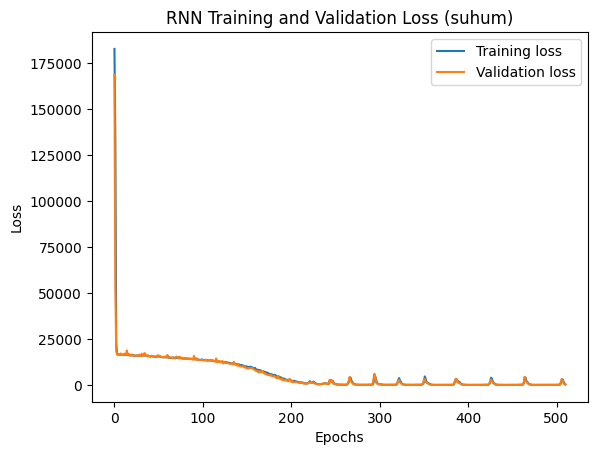

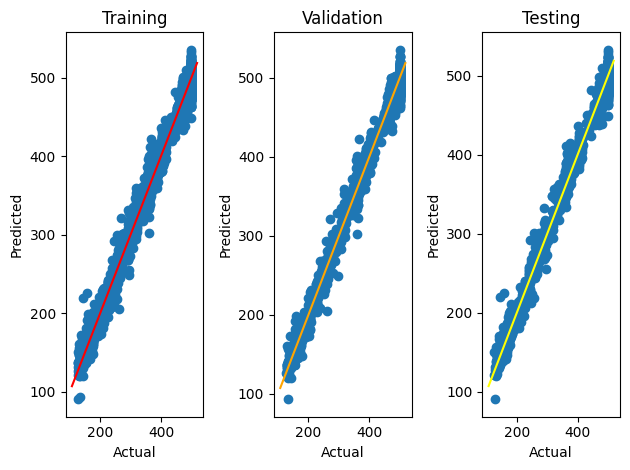

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_rnn_saved_model\assets


INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_rnn_saved_model\assets


<Figure size 640x480 with 0 Axes>

In [ ]:
# Start MLflow run
with mlflow.start_run():

    # Log parameters
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "recurrent_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.set_tag("experiment", "Suhum")
    mlflow.log_param("Data-path", r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Suhum.csv")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)

    # Recurrent neural network model architecture (LSTM)
    rnn_model = Sequential()
    rnn_model.add(LSTM(1000, activation="relu", input_shape=(x_train.shape[1], 1)))
    rnn_model.add(Dense(500, activation='relu'))
    rnn_model.add(Dense(250, activation='relu'))
    rnn_model.add(Dense(1, activation='linear'))

    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(rnn_model, 'rnn_model')

    rnn_model.summary()

    rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                             mode='min',
                             patience=patience)

    history = rnn_model.fit(x_train_cnn, y_train,
                            epochs=epochs,
                            callbacks=[earlyStop],
                            batch_size=batch_size,
                            validation_data=(x_val_cnn, y_val),
                            verbose=1)

    # Log metrics
    mlflow.log_metric('suhum_final_training_loss', history.history['loss'][-1])
    mlflow.log_metric('suhum_final_validation_loss', history.history['val_loss'][-1])

    # Predictions
    train_preds = rnn_model.predict(x_train_cnn)
    val_preds = rnn_model.predict(x_val_cnn)
    test_preds = rnn_model.predict(x_test_cnn)

    # Evaluate on the test set
    rnn_results = rnn_model.evaluate(x_test_cnn, y_test)

    # MAE
    rnn_train_mae = mean_absolute_error(y_train, train_preds)
    rnn_val_mae = mean_absolute_error(y_val, val_preds)
    rnn_test_mae = rnn_results[1]

    # MSE
    rnn_train_mse = mean_squared_error(y_train, train_preds)
    rnn_val_mse = mean_squared_error(y_val, val_preds)
    rnn_test_mse = rnn_results[0]

    # RMSE
    rnn_train_rmse = np.sqrt(rnn_train_mse)
    rnn_val_rmse = np.sqrt(rnn_val_mse)
    rnn_test_rmse = np.sqrt(rnn_test_mse)

    # R-Square
    rnn_train_r2 = r2_score(y_train, train_preds)
    rnn_val_r2 = r2_score(y_val, val_preds)
    rnn_test_r2 = r2_score(y_test, test_preds)

    # MAPE
    rnn_train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    rnn_val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    rnn_test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

    # AIC calculation for the RNN
    n_samples_rnn = len(y_train)
    log_likelihood_rnn = -0.5 * n_samples_rnn * np.log(2 * np.pi * rnn_train_mse) - 0.5 * n_samples_rnn
    n_params_rnn = sum([np.prod(w.shape) for w in rnn_model.get_weights()])
    aic_rnn = -2 * log_likelihood_rnn + 2 * n_params_rnn

    # Log AIC as a metric
    mlflow.log_metric("suhum_aic_rnn", aic_rnn)

    # Logging metrics
    mlflow.log_metric('suhum_rnn_train_mae', rnn_train_mae)
    mlflow.log_metric('suhum_rnn_val_mae', rnn_val_mae)
    mlflow.log_metric('suhum_rnn_test_mae', rnn_test_mae)

    mlflow.log_metric('suhum_rnn_train_mse', rnn_train_mse)
    mlflow.log_metric('suhum_rnn_val_mse', rnn_val_mse)
    mlflow.log_metric('suhum_rnn_test_mse', rnn_test_mse)

    mlflow.log_metric("suhum_rnn_train_rmse", rnn_train_rmse)
    mlflow.log_metric("suhum_rnn_val_rmse", rnn_val_rmse)
    mlflow.log_metric("suhum_rnn_test_rmse", rnn_test_rmse)

    mlflow.log_metric("suhum_rnn_train_r2", rnn_train_r2)
    mlflow.log_metric("suhum_rnn_val_r2", rnn_val_r2)
    mlflow.log_metric("suhum_rnn_test_r2", rnn_test_r2)

    mlflow.log_metric("suhum_rnn_train_mape", rnn_train_mape)
    mlflow.log_metric("suhum_rnn_val_mape", rnn_val_mape)
    mlflow.log_metric("suhum_rnn_test_mape", rnn_test_mape)

    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('RNN Training and Validation Loss (suhum)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    loss_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_rnn_loss_plot.png'

    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)

    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("Testing")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='yellow')

    # Tight layout
    fig.tight_layout()

    plt.show()

    # Save scatter plot
    scatter_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_rnn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)

    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_rnn_saved_model'
    rnn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)
    mlflow.end_run()

### 4. Neural Network Ensemble

51/51 [==============================] - 1s 26ms/step
Epoch 1/20
26/26 [==============================] - 1s 8ms/step - loss: 49133.9688 - mae: 196.2296 - val_loss: 5067.5181 - val_mae: 66.9756
Epoch 2/20
26/26 [==============================] - 0s 4ms/step - loss: 1009.1247 - mae: 24.2135 - val_loss: 584.8268 - val_mae: 21.9839
Epoch 3/20
26/26 [==============================] - 0s 4ms/step - loss: 255.4173 - mae: 12.7324 - val_loss: 79.7260 - val_mae: 6.9941
Epoch 4/20
26/26 [==============================] - 0s 4ms/step - loss: 90.0269 - mae: 7.3477 - val_loss: 74.5523 - val_mae: 6.7494
Epoch 5/20
26/26 [==============================] - 0s 4ms/step - loss: 82.0700 - mae: 7.0311 - val_loss: 72.8656 - val_mae: 6.6370
Epoch 6/20
26/26 [==============================] - 0s 3ms/step - loss: 79.1061 - mae: 6.9099 - val_loss: 71.7754 - val_mae: 6.5878
Epoch 7/20
26/26 [==============================] - 0s 4ms/step - loss: 78.0163 - mae: 6.8922 - val_loss: 71.1129 - val_mae: 6.5875
Epoch 8

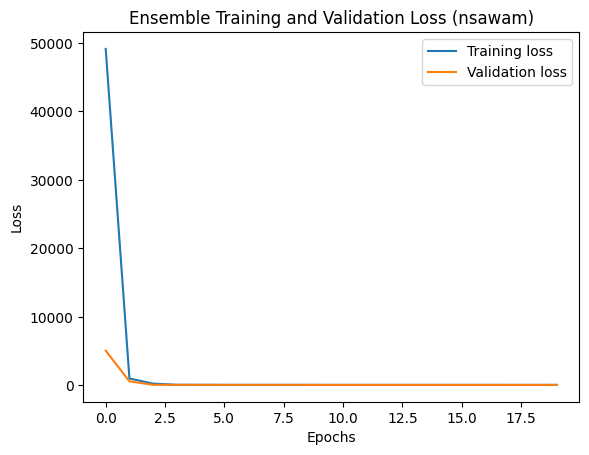

51/51 [==============================] - 1s 23ms/step
Epoch 1/20
26/26 [==============================] - 1s 9ms/step - loss: 80990.7891 - mae: 257.0425 - val_loss: 13508.9268 - val_mae: 109.7084
Epoch 2/20
26/26 [==============================] - 0s 3ms/step - loss: 2853.8596 - mae: 39.3063 - val_loss: 850.7921 - val_mae: 26.7509
Epoch 3/20
26/26 [==============================] - 0s 4ms/step - loss: 383.4326 - mae: 15.7436 - val_loss: 122.1246 - val_mae: 8.6785
Epoch 4/20
26/26 [==============================] - 0s 4ms/step - loss: 155.3495 - mae: 9.3387 - val_loss: 115.0681 - val_mae: 8.4852
Epoch 5/20
26/26 [==============================] - 0s 5ms/step - loss: 135.1434 - mae: 8.8212 - val_loss: 104.7937 - val_mae: 8.1250
Epoch 6/20
26/26 [==============================] - 0s 4ms/step - loss: 125.2304 - mae: 8.4786 - val_loss: 98.7808 - val_mae: 7.8737
Epoch 7/20
26/26 [==============================] - 0s 4ms/step - loss: 117.2398 - mae: 8.2350 - val_loss: 91.9760 - val_mae: 7.627

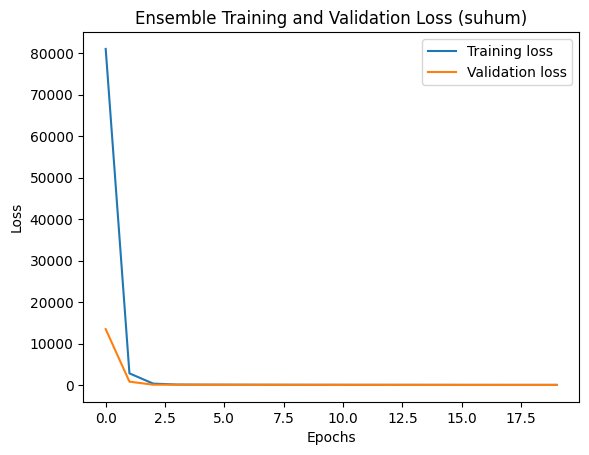

51/51 [==============================] - 0s 2ms/step


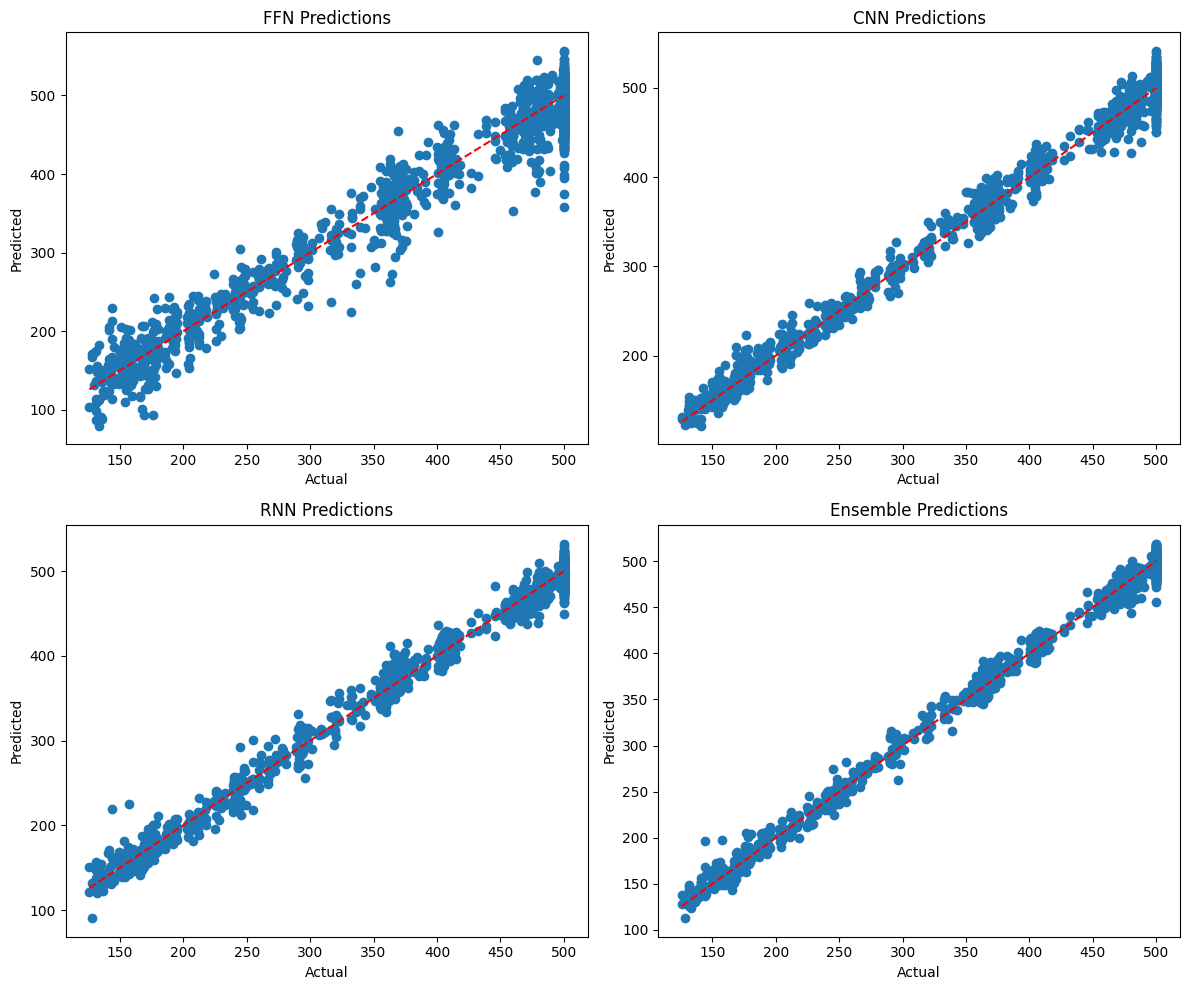

In [ ]:
import joblib

# Check if there is an active run
active_run = mlflow.active_run()
if active_run:
    # End the active run
    mlflow.end_run()

# Starting MLflow run
with mlflow.start_run():
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "neural_network_ensemble")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.set_tag("experiment", "Suhum")
    mlflow.log_param("Data-path", r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Suhum.csv")

    # Make predictions on the validation set using each model
    val_preds_ffn = ffn_model.predict(x_val)
    val_preds_cnn = cnn_model.predict(x_val_cnn)
    val_preds_rnn = rnn_model.predict(x_val_cnn)

    # Combine the predictions into a single input for the ensemble
    stacked_input_val = np.concatenate((val_preds_ffn, val_preds_cnn, val_preds_rnn), axis=1)

    # Create the Stacked Ensemble Model
    stacked_ensemble = Sequential()
    stacked_ensemble.add(Dense(100, activation='relu', input_shape=(3,)))
    stacked_ensemble.add(Dense(1, activation='linear'))

    # Compile the ensemble model
    stacked_ensemble.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Train the ensemble model on the stacked predictions
    history_ensemble = stacked_ensemble.fit(stacked_input_val, y_val, epochs=20, batch_size=batch_size, validation_split=0.2)

    # Log training and validation performance
    mlflow.log_metric("nsawam_ensemble_train_loss", history_ensemble.history['loss'][-1])
    mlflow.log_metric("nsawam_ensemble_val_loss", history_ensemble.history['val_loss'][-1])

    # Plot the loss for the ensemble during training and validation
    plt.plot(history_ensemble.history['loss'], label='Training loss')
    plt.plot(history_ensemble.history['val_loss'], label='Validation loss')
    plt.title('Ensemble Training and Validation Loss (nsawam)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the loss plot
    loss_plot_path_ensemble = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ensemble_loss_plot.png'
    plt.savefig(loss_plot_path_ensemble)
    mlflow.log_artifact(loss_plot_path_ensemble)

    # Show the loss plot
    plt.show()

        # Make predictions on the validation set using each model
    val_preds_ffn = ffn_model.predict(x_val)
    val_preds_cnn = cnn_model.predict(x_val_cnn)
    val_preds_rnn = rnn_model.predict(x_val_cnn)

    # Combine the predictions into a single input for the ensemble
    stacked_input_val = np.concatenate((val_preds_ffn, val_preds_cnn, val_preds_rnn), axis=1)

    # Create the Stacked Ensemble Model
    ensemble_model = Sequential()
    ensemble_model.add(Dense(100, activation='relu', input_shape=(3,)))
    ensemble_model.add(Dense(1, activation='linear'))

    # Compile the ensemble model
    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Train the ensemble model on the stacked predictions
    history_ensemble = ensemble_model.fit(stacked_input_val, y_val, epochs=20, batch_size=batch_size, validation_split=0.2)

    # Log training and validation performance
    mlflow.log_metric("suhum_ensemble_train_loss", history_ensemble.history['loss'][-1])
    mlflow.log_metric("suhum_ensemble_val_loss", history_ensemble.history['val_loss'][-1])

    # Plot the loss for the ensemble during training and validation
    plt.plot(history_ensemble.history['loss'], label='Training loss')
    plt.plot(history_ensemble.history['val_loss'], label='Validation loss')
    plt.title('Ensemble Training and Validation Loss (suhum)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the loss plot
    loss_plot_path_ensemble = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_ensemble_loss_plot.png'
    plt.savefig(loss_plot_path_ensemble)
    mlflow.log_artifact(loss_plot_path_ensemble)

    # Show the loss plot
    plt.show()

    # Make predictions on the test set using each model
    test_preds_ffn = ffn_model.predict(x_test)
    test_preds_cnn = cnn_model.predict(x_test_cnn)
    test_preds_rnn = rnn_model.predict(x_test_cnn)

    # Combine the predictions into a single input for the ensemble
    stacked_input_test = np.concatenate((test_preds_ffn, test_preds_cnn, test_preds_rnn), axis=1)

    # Make predictions using the stacked ensemble
    ensemble_preds = stacked_ensemble.predict(stacked_input_test)

    # Scatter plots for individual models and ensemble
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Feed-Forward Neural Network
    axes[0, 0].scatter(x=y_test, y=test_preds_ffn)
    axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[0, 0].set_xlabel("Actual", fontsize=10)
    axes[0, 0].set_ylabel("Predicted", fontsize=10)
    axes[0, 0].set_title("FFN Predictions")

    # Convolutional Neural Network
    axes[0, 1].scatter(x=y_test, y=test_preds_cnn)
    axes[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[0, 1].set_xlabel("Actual", fontsize=10)
    axes[0, 1].set_ylabel("Predicted", fontsize=10)
    axes[0, 1].set_title("CNN Predictions")

    # Long Short-Term Memory RNN
    axes[1, 0].scatter(x=y_test, y=test_preds_rnn)
    axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[1, 0].set_xlabel("Actual", fontsize=10)
    axes[1, 0].set_ylabel("Predicted", fontsize=10)
    axes[1, 0].set_title("RNN Predictions")

    # Stacked Ensemble
    axes[1, 1].scatter(x=y_test, y=ensemble_preds)
    axes[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[1, 1].set_xlabel("Actual", fontsize=10)
    axes[1, 1].set_ylabel("Predicted", fontsize=10)
    axes[1, 1].set_title("Ensemble Predictions")

    # Tight layout
    fig.tight_layout()

    # Save scatter plots
    scatter_plots_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_ensemble_scatter_plot.png'
    plt.savefig(scatter_plots_path)
    mlflow.log_artifact(scatter_plots_path)

    # Show the scatter plots
    plt.show()

    # Evaluate the performance of the stacked ensemble
    ensemble_mse = mean_squared_error(y_test, ensemble_preds)
    ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
    ensemble_r2 = r2_score(y_test, ensemble_preds)
    ensemble_rmse = np.sqrt(ensemble_mse)
    ensemble_mape = np.mean(np.abs((y_val - ensemble_preds.flatten()) / y_val)) * 100

    # Log testing performance
    mlflow.log_metric("suhum_ensemble_test_mae", ensemble_mae)
    mlflow.log_metric("suhum_ensemble_test_mse", ensemble_mse)
    mlflow.log_metric("suhum_ensemble_test_rmse", ensemble_rmse)
    mlflow.log_metric("suhum_ensemble_test_r2", ensemble_r2)
    mlflow.log_metric("suhum_ensemble_test_mape", ensemble_mape)

    # Get the number of parameters in the ensemble model
    num_params_ensemble = stacked_ensemble.count_params()

    # Calculate AIC
    max_log_likelihood = -0.5 * min(history_ensemble.history['val_loss'])
    aic_ensemble = 2 * num_params_ensemble - 2 * max_log_likelihood

    # Log AIC
    mlflow.log_metric("suhum_ensemble_aic", aic_ensemble)

    # Saving the ensemble model as a pickle file
    joblib.dump(ensemble_model, r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_ensemble_model.pkl')

    # Log the ensemble model as an artifact
    mlflow.log_artifact(r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\suhum_ensemble_model.pkl')

### Print results

In [ ]:
print("Feed Forward Neural Network Results")
print(" ")
print("AIC: ", aic_ffn)
print("")
print("Training:")
print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAPE:", train_mape)
print("Train R-squared:", train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", val_mae)
print("Validation MSE:", val_mse)
print("Validation RMSE:", val_rmse)
print("Validation MAPE:", val_mape)
print("Validation R-squared:", val_r2)

print(" ")
print("Testing:")
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAPE:", test_mape)
print("Test R-squared:", test_r2)

Feed Forward Neural Network Results
 
AIC:  1300144.688141246

Training:
Train MAE: 19.543383
Train MSE: 692.7587
Train RMSE: 26.32031
Train MAPE: 5.842199921607971
Train R-squared: 0.9580457489496339
 
Validation:
Validation MAE: 19.662727
Validation MSE: 711.4779
Validation RMSE: 26.673544
Validation MAPE: 5.868234112858772
Validation R-squared: 0.9571665080243372
 
Testing:
Test MAE: 19.424034118652344
Test MSE: 674.0394287109375
Test RMSE: 25.96226932898851
Test MAPE: 5.8161661028862
Test R-squared: 0.958925818944627


In [ ]:
print("Convolutional Network Results")
print(" ")
print("AIC: ", aic_cnn)
print("")
print("Training:")
print("Train MAE:", cnn_train_mae)
print("Train MSE:", cnn_train_mse)
print("Train RMSE:", cnn_train_rmse)
print("Train MAPE:", cnn_train_mape)
print("Train R-squared:", cnn_train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", cnn_val_mae)
print("Validation MSE:", cnn_val_mse)
print("Validation RMSE:", cnn_val_rmse)
print("Validation MAPE:", cnn_val_mape)
print("Validation R-squared:", cnn_val_r2)

print(" ")
print("Testing:")
print("Test MAE:", cnn_test_mae)
print("Test MSE:", cnn_test_mse)
print("Test RMSE:", cnn_test_rmse)
print("Test MAPE:", cnn_test_mape)
print("Test R-squared:", cnn_test_r2)

Convolutional Network Results
 
AIC:  1785565.1477836433

Training:
Train MAE: 10.085503
Train MSE: 166.63557
Train RMSE: 12.90874
Train MAPE: 2.946780249476433
Train R-squared: 0.9899083606969294
 
Validation:
Validation MAE: 10.206333
Validation MSE: 171.04628
Validation RMSE: 13.078466
Validation MAPE: 2.9838528484106064
Validation R-squared: 0.989702406818913
 
Testing:
Test MAE: 9.964672088623047
Test MSE: 162.22491455078125
Test RMSE: 12.73675447477815
Test MAPE: 2.9097074642777443
Test R-squared: 0.9901144464985002


In [ ]:
print("Recurrent Neural Network")
print(" ")
print("AIC: ", aic_rnn)
print(" ")
print("Training:")
print("Train MAE:", rnn_train_mae)
print("Train MSE:", rnn_train_mse)
print("Train RMSE:", rnn_train_rmse)
print("Train MAPE:", rnn_train_mape)
print("Train R-squared:", rnn_train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", rnn_val_mae)
print("Validation MSE:", rnn_val_mse)
print("Validation RMSE:", rnn_val_rmse)
print("Validation MAPE:", rnn_val_mape)
print("Validation R-squared:", rnn_val_r2)

print(" ")
print("Testing:")
print("Test MAE:", rnn_test_mae)
print("Test MSE:", rnn_test_mse)
print("Test RMSE:", rnn_test_rmse)
print("Test MAPE:", rnn_test_mape)
print("Test R-squared:", rnn_test_r2)

Recurrent Neural Network
 
AIC:  9293068.763081085
 
Training:
Train MAE: 9.126607
Train MSE: 142.78853
Train RMSE: 11.949415
Train MAPE: 2.7428125962615013
Train R-squared: 0.9913525659254173
 
Validation:
Validation MAE: 9.012341
Validation MSE: 139.75047
Validation RMSE: 11.82161
Validation MAPE: 2.717781625688076
Validation R-squared: 0.9915865257897336
 
Testing:
Test MAE: 9.240873336791992
Test MSE: 145.82655334472656
Test RMSE: 12.075866567030564
Test MAPE: 2.7678437530994415
Test R-squared: 0.9911137164179593


In [ ]:
print("Neural Network Ensemble")
print(" ")
print("AIC: ", aic_ensemble)
print(" ")
print("Testing:")
print("Test MAE:", ensemble_mae)
print("Test MSE:", ensemble_mse)
print("Test RMSE:", ensemble_rmse)
print("Test MAPE:", ensemble_mape)
print("Test R-squared:", ensemble_r2)

Neural Network Ensemble
 
AIC:  1067.8404541015625
 
Testing:
Test MAE: 6.655231
Test MSE: 75.34665
Test RMSE: 8.680244
Test MAPE: 48.790243268013
Test R-squared: 0.9954085753761075
